# Explore Southern Ocean - East Pacific Teleconnection
Examine how this is mediated by SWCF

In [306]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
from typing import Tuple

# Utils

In [2]:
# Choose a colormap
cmap_name = "RdYlBu_r"  # Replace with your desired colormap (e.g., "RdYlBu")
cmap = plt.cm.get_cmap(cmap_name)

# Sample the colormap at 256 evenly spaced points
n_colors = 50
colors = cmap(np.linspace(0, 1, n_colors))
colors = [*colors[:23], [1,1,1,1], [1,1,1,1], [1,1,1,1], [1,1,1,1], *colors[27:]]
mpl.colormaps.register(LinearSegmentedColormap.from_list('RdYlWhBu_r', colors))

/tmp/ipykernel_359997/28081108.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


In [3]:
cdict2 = [
    (36,   0, 216),
    (24,  28, 247),
    (40,  87, 255),
    (61, 135, 255),
    (86, 176, 255),
    (117, 211, 255),
    (153, 234, 255),
    (188, 249, 255),
    (234, 255, 255),
    (255, 255, 234),
    (255, 241, 188),
    (255, 214, 153),
    (255, 172, 117),
    (255, 120,  86),
    (255,  61,  61),
    (247,  39,  53),
    (216,  21,  47),
    (165,   0,  33),
]
# Convert to 0 to 1
cdict2 = [(r/255, g/255, b/255) for i, (r, g, b) in enumerate(cdict2)]
mpl.cm.unregister_cmap("BWYR")
mpl.colormaps.register(LinearSegmentedColormap.from_list('BWYR', cdict2))

/tmp/ipykernel_359997/491978629.py:23: MatplotlibDeprecationWarning: The unregister_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.unregister(name)`` instead.
  mpl.cm.unregister_cmap("BWYR")


In [223]:
def create_panel_a(ax, x6, y6, x5: list = [], y5: list = [], vline=0) -> None:
    # Set the default color cycle
    colors = ['black','maroon','#7570b3']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

    CMIP6_label = "CMIP6"
    
    if len(x5) != 0: 
        slope, intercept, r, p, _ = linregress(x5,y5)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP5_label = f"r={r}"
        ax.scatter(x5, y5, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP5_label)

        slope, intercept, r, p, _ = linregress(x6,y6)
        r, p = np.around(r, 3), np.around(p, 3)
        CMIP6_label = f"r={r}"
    
    ax.scatter(x6, y6, s=100, alpha=.5, edgecolor="black", color=colors[0], label=CMIP6_label)

    # Multimodel mean
    mmm = np.mean([*x5, *x6])


    x = np.concatenate((x6, x5))
    y = np.concatenate((y6, y5))
    # Sort the lists together based on list1
    x, y  = zip(*sorted(zip(x, y)))

    slope, intercept, r, p, _ = linregress(x,y)
    r, p = np.around(r, 3), np.around(p, 3)
    if p < .05: 
        sig = '*'
    else: 
        sig = ''
    print(r, p)

    x = np.array(sorted(x))
    ax.plot(x, x*slope+intercept, color="black")
    # ax.legend(loc="upper left", fontsize=fontsize)
    ax.set_title(f"r={r}{sig}", loc="right", fontweight="bold", fontsize=16)
    
    
    # Define border size - important for emphasizing relationships
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    borderx, bordery = .25*abs(np.max(x)), .25*abs(np.max(y))
    ax.set_xlim(xmin-borderx, xmax+borderx)
    ax.set_ylim(ymin-bordery, ymax+bordery)

    # Vertical line for avg and std of obs
    ax.vlines(np.mean(vline), ymin=ymin-bordery, ymax=ymax+bordery, color="navy")
    ax.fill_between(x=[np.mean(vline) - np.std(vline), np.mean(vline) + np.std(vline)], y1=ymin-bordery, y2=ymax+bordery,color="navy", alpha=.25)

    # Add Model Vertical Lines
    ax.vlines(mmm, ymin=ymin-bordery, ymax=ymax+bordery, color=colors[0], label='_nolegend_', alpha=.5, linewidth=2, zorder=0) 
    # ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=-1, y2=2.5, color="black", alpha=.25)
    ax.fill_between(x=[mmm - np.std(x), mmm + np.std(x)], y1=np.min(y)*5-50, y2=np.max(y)*5+50, color="black", alpha=.25)

    # Add horizontal sigma lines
    sig_mmm = mmm*slope+intercept
    sig_obs = np.mean(vline)*slope+intercept
    hline_width = 3
    ax.hlines(y=sig_mmm, xmin=xmin-borderx, xmax=mmm, color="black", linewidth=hline_width)
    ax.hlines(y=sig_obs, xmin=xmin-borderx, xmax=np.mean(vline), color="orange", linewidth=hline_width)

    ax.text(s=f"{np.around(sig_mmm, 2)}", x=xmin-borderx*.95, y=sig_mmm + sig_mmm*.025, color="black", fontsize=12, fontweight="bold")
    ax.text(s=f"{np.around(sig_obs, 2)}", x=xmin-borderx*.95, y=sig_obs + sig_mmm*.025, color="orange", fontsize=12, fontweight="bold")

In [5]:
def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, ntime, _, nlon = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:,:nlats,i] = np.full((nmodel, ntime, nlats), np.nan) 
        
        jold = j
    
    return ctos

def get_shared_models(ds1: xr.Dataset, ds2: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    # print(len(shared_models), len(np.unique(shared_models)))
    # return shared_models
    return ds1.sel(model=shared_models), ds2.sel(model=shared_models)

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def fix_coords_no_time(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(0, 360))
    return data

def fix_coords_no_time_no_swap(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def fix_coords_no_space(data):
    data = data.bounds.add_bounds("T")
    return data

def fix_coords_no_swap(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    return data


In [322]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    # plot map of global data with central longitude 180
    # Uncomment for reds
    # cmap = matplotlib.cm.get_cmap(cmap)
    # norm = matplotlib.colors.Normalize(vmin=np.min(levels), vmax=np.max(levels))
    # cmap = [cmap(norm(l)) for l in levels]
    # cmap[0] = (1, 1, 1, 1) # Set first element to white
    
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        # colors=cmap, # uncomment for reds
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    if contours is not None:
        ax.contour(
            lon, lat, contours,
            transform=ccrs.PlateCarree(),
            colors="black",
            levels=[-300, -200, -100, 0, 100, 125, 150, 175, 200]
        )
    if pr is not None:
        ax.contour(
            lon, lat, pr,
            transform=ccrs.PlateCarree(),
            # cmap="magenta",
            colors="magenta",
            # levels=[-2, -1.2, .4, .6],
            levels=[-6, 6],
        )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
    if wind is not None:
        # Scale reg maps 25 
        q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=150, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        ax.quiverkey(q, .9, -.15, .25, str(.25) + r' $\frac{m}{s}/\sigma$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    # lat_min, lat_max = -40, 0
    # lon_min, lon_max = -180, -70
    # ax.plot(
    #     [lon_min, lon_max, lon_max, lon_min], 
    #     [lat_max, lat_max, lat_min, lat_max], 
    #     color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    # )

    # # East Pacific South America
    # bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")
    # bound_region(ax, lons=(110, 150), lats=(-5, 5), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 90
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
    cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    


# Load Data

In [307]:
# SSTs
cmip6_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP6_piControl.nc"))
cmip5_monthly_ssts = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP5_piControl.nc"))

# Replace all 0s with nans
cmip5_monthly_ssts["tos"] = cmip5_monthly_ssts["tos"].where(cmip5_monthly_ssts["tos"] != 0)
cmip5_monthly_ssts["tos"] = cmip5_monthly_ssts["tos"] - 273.15
cmip_ssts = fix_coords(xr.concat([cmip6_monthly_ssts, cmip5_monthly_ssts], dim="model"))

swcf_cmip6 = xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip6_monthly_1850-2000.nc')
swcf_cmip5 = xr.open_dataset('/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_cmip5_monthly_1850-2000.nc')
swcf_cmip = xr.concat([swcf_cmip6, swcf_cmip5], dim="model")

cmip6_ept_ssts = fix_coords(get_triangle(cmip6_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]
cmip5_ept_ssts = fix_coords(get_triangle(cmip5_monthly_ssts.tos.copy(deep=True)).to_dataset()).spatial.average("tos").temporal.departures("tos", "month")["tos"]

cmip6_so_ssts = cmip6_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"]
cmip5_so_ssts = cmip5_monthly_ssts.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos").temporal.departures("tos", "month")["tos"] 

cmip_so_ssts = xr.concat([cmip6_so_ssts, cmip5_so_ssts], dim="model")
cmip_ept_ssts = xr.concat([cmip6_ept_ssts, cmip5_ept_ssts], dim="model")

# WindSpeed
cmip6_monthly_uas = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/uas_mon_1850-2100_CMIP6_piControl.nc"))
cmip5_monthly_uas = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/uas_mon_1850-2100_CMIP5_piControl.nc"))
cmip_monthly_uas = xr.concat([cmip6_monthly_uas, cmip5_monthly_uas], dim="model")

cmip6_monthly_vas = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/vas_mon_1850-2100_CMIP6_piControl.nc"))
cmip5_monthly_vas = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/vas_mon_1850-2100_CMIP5_piControl.nc"))
cmip_monthly_vas = xr.concat([cmip6_monthly_vas, cmip5_monthly_vas], dim="model")

# SWCRE
cmip6_monthly_swcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcre_cmip6_monthly_1850-2000.nc"))
cmip5_monthly_swcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcre_cmip5_monthly_1850-2000.nc"))
cmip_monthly_swcre = xr.concat([cmip6_monthly_swcre, cmip5_monthly_swcre], dim="model")

cmip6_monthly_lwcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/lwcre_cmip6_monthly_1850-2000.nc"))
cmip5_monthly_lwcre = fix_coords(xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/lwcre_cmip5_monthly_1850-2000.nc"))
cmip_monthly_lwcre = xr.concat([cmip6_monthly_lwcre, cmip5_monthly_lwcre], dim="model")

# TOA SWCF
swcf_cmip6_epsa = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip6_v3.nc") 
swcf_cmip5_epsa = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcf_east_sa_cmip5_v3.nc") 
swcf_cmip_epsa = xr.concat([swcf_cmip6_epsa, swcf_cmip5_epsa], dim="model")

# 30-year Trends
# sst_ept_cmip6 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc")
# sst_ept_cmip5 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc")
# sst_ept_cmip = xr.concat([sst_ept_cmip6, sst_ept_cmip5], dim="model")

# sst_so_cmip6 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip6_southernOcean_trend.nc")
# sst_so_cmip5 = xr.open_dataarray("/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_cmip5_southernOcean_trend.nc")
# sst_so_cmip = xr.concat([sst_so_cmip6, sst_so_cmip5], dim="model")

# 4xCO2
sst_cmip6_4xc02 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/4xCO2/tos_mon_150yrs_CMIP6_4xCO2.nc")
sst_cmip5_4xc02 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/4xCO2/tos_mon_150yrs_CMIP5_4xCO2.nc")
sst_cmip_4xc02 = fix_coords(xr.concat([sst_cmip6_4xc02, sst_cmip5_4xc02], dim="model"))

cmip_4xc02_ept_sst = fix_coords(get_triangle(sst_cmip_4xc02.tos.copy(deep=True)).to_dataset()).spatial.average("tos") #.temporal.departures("tos", "month")["tos"]
cmip_4xc02_so_sst = sst_cmip_4xc02.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos") #.temporal.departures("tos", "month")["tos"]
cmip_4xc02_global_sst = sst_cmip_4xc02.spatial.average("tos") #.temporal.departures("tos", "month")["tos"]

# PSL 
psl_cmip6 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/psl_mon_1850-2100_CMIP6_piControl.nc")
psl_cmip5 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/psl_mon_1850-2100_CMIP5_piControl.nc")
psl_cmip = fix_coords(xr.concat([psl_cmip6, psl_cmip5], dim="model"))

pr_cmip6 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP6_piControl.nc")
pr_cmip5 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP5_piControl.nc")
pr_cmip =  xr.concat([pr_cmip6, pr_cmip5], dim="model")

For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5
For each latitude step of 2.5 degrees, longitude step is 7.5


In [213]:
# Calculate ITCZ
"""
Precipitation Asymmetry Index. We quantify the eastern Pacific ITCZ shift by calculating the precipitation 
in the northern tropical eastern Pacific (230°E–290°E, 0°–20°N) minus the precipitation in the southern tropical 
eastern Pacific (230°E–290°E, 20°S–0°), normalized by the tropical eastern Pacific precipitation (230°E–290°E, 20°S–20°N).
This is defined as the precipitation asymmetry index over the tropical eastern Pacific, denoted as PAIEP. A positive 
PAIEP response indicates a northward eastern Pacific ITCZ shift.
"""
pr_cmip = fix_coords_no_swap(pr_cmip)
pr_north_east = pr_cmip.sel(lon=slice(230, 290), lat=slice(0, 20)).spatial.average("pr")["pr"]
pr_south_east = pr_cmip.sel(lon=slice(230, 290), lat=slice(-20, 0)).spatial.average("pr")["pr"]
pr_total_east = pr_cmip.sel(lon=slice(230, 290), lat=slice(-20, 20)).spatial.average("pr")["pr"]
# Calculate Double ITCZ Metric (PAIEP)
paiep = (pr_north_east - pr_south_east) / pr_total_east
paiep_clim = paiep.mean("time") # Climatology (one value for each model)
paiep_clim
# Calculate ITCZ Positin Metric (Latitude of maximum zonal mean precip in East Pacific)
itcz_position = pr_cmip.sel(lon=slice(230, 290), lat=slice(-20, 20)).mean("lon")["pr"].resample(time="1Y").mean("time").idxmax(dim="lat")
itcz_position
# Calculate Southern Precip Bias
pr_south_east = pr_cmip.sel(lon=slice(230, 270), lat=slice(-20, 0)).spatial.average("pr")["pr"]
pr_south_east_clim = pr_south_east.mean("time")*86400

In [193]:
# Calculate Walker Circulation
west = psl_cmip.sel(lat=slice(-5, 5), lon=slice(130, 150)).spatial.average("psl")["psl"]
east = psl_cmip.sel(lat=slice(-5, 5), lon=slice(-180, -80)).spatial.average("psl")["psl"]
walker = fix_coords_no_space((east - west).to_dataset(name="walker"))
walker_anomaly = walker.temporal.departures("walker", "month")["walker"]
walker_anomaly 

<xarray.DataArray 'walker' (model: 100, time: 1800)>
array([[  -7.21350422,  -34.90539243,   59.06068062, ...,   22.14488646,
         -71.26372044,   56.19141586],
       [  -6.9107375 ,   -6.33064756,  -68.21341823, ...,   42.2496872 ,
          27.7190441 ,   89.08904231],
       [ 113.35450587,  100.64003115,   79.66260182, ...,  144.44428587,
         162.75592452,   98.73213684],
       ...,
       [-285.62612687, -324.60725361, -239.5485147 , ...,  -97.72670602,
        -129.90127016, -163.53394034],
       [ -73.63460242, -177.73268205, -100.69407564, ...,  -44.12324412,
         -38.63360475,  -94.69708719],
       [  27.45665168,    1.84706317,  104.23939359, ...,  -43.2585115 ,
         -52.69523751,  -47.16048483]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1999-12-01
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'MRI-CGCM3' 'CNRM-CM5-2'
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

In [194]:
# Calculate Walker Circulation
west = fix_coords(cmip_ssts["tos"].to_dataset()).sel(lat=slice(-5, 5), lon=slice(110, 150)).spatial.average("tos")["tos"]
east = fix_coords(cmip_ssts["tos"].to_dataset()).sel(lat=slice(-5, 5), lon=slice(-180, -80)).spatial.average("tos")["tos"]
WE_sst = fix_coords_no_space((west - east).to_dataset(name="WE_sst"))
WE_sst_anomaly = WE_sst.temporal.departures("WE_sst", "month")["WE_sst"]
WE_sst_anomaly 

<xarray.DataArray 'WE_sst' (model: 94, time: 1800)>
array([[-1.12012047e-01, -3.12775308e-02, -2.06822434e-01, ...,
         5.55647025e-01,  3.05672191e-01,  2.70680759e-01],
       [ 6.25442897e-02, -5.43227789e-01, -6.98290039e-01, ...,
         8.78018370e-01,  1.24865251e+00,  1.03673522e+00],
       [-1.11868191e+00, -1.29970275e+00, -1.10777762e+00, ...,
        -3.60534930e-01, -7.29088028e-01, -9.27056073e-01],
       ...,
       [-2.92714671e+00, -3.22572789e+00, -3.02217601e+00, ...,
        -1.71792802e+00, -1.55704105e+00, -1.61172515e+00],
       [ 7.51094932e-01,  1.25898743e+00,  1.51307639e+00, ...,
        -9.06516412e-01, -4.01709902e-01, -1.06060266e-01],
       [ 4.10033076e-01,  6.52826910e-02,  1.70307414e-01, ...,
        -1.11069939e-01, -6.13975107e-01, -2.11284579e-03]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1999-12-01
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'FIO-ESM' 'CNRM-CM5-2'
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True

In [308]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_{name}.nc")
    
    grads = np.zeros((data.model.size, int((len(data.time) - window) / step)))
    grads.fill(np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        grads[:,j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values

    # Convert to xarray
    da =  xr.DataArray(grads*window, dims=("model", "time"), coords={"model": data.model, "time": np.arange(grads.shape[1])})
    if save:
        da.to_netcdf(f"/home/espinosa10/tropical_pacific_clouds/data/piControl/rolling_gradient_{name}.nc")
    
    return da


In [309]:
def get_rolling_timeseries(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", gradient: bool = False) -> xr.DataArray:
    """Get the rolling timeseries of a dataset (optionally calculate gradient)

    Args:
        data (xr.DataArray): Input data.
        window (int, optional): Size of the rolling window. Defaults to 12*30.
        step (int, optional): Step size for each window. Defaults to 12.
        gradient (bool, optional): Calculate gradient if True, mean if False. Defaults to False.

    Returns:
        xr.DataArray: Resulting timeseries with same shape as input.
    """
    
    # Prepare output array with the same shape as input data
    new_time_size = 1 + (len(data.time) - window) // step
    rolling_shape = list(data.shape)
    rolling_shape[data.get_axis_num('time')] = new_time_size

    # Prepare output array with the adjusted shape
    rolling = np.full(rolling_shape, np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    # Loop to compute rolling statistics over time dimension
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if gradient:
            rolling[:,j] = window*xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        else:
            rolling[:,j] = data.isel(time=slice(i, i+window)).mean(dim="time").values

    # Convert to xarray
    da = xr.DataArray(rolling, dims=data.dims, coords={**data.coords, 'time': np.arange(rolling.shape[1])})

    return da


# Calculate Coupling Strength as a function of timescale and lagged

In [13]:
lags = np.arange(-12*5, 12*5)

def lagged_regression(ts_so_ssts, ts_ept_ssts, lags):
    reg_coeffs, rvalues, pvalues = [], [], []
    for lag in lags:
        rvalues.append(xscore.pearson_r(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))


    reg_coeffs = xr.Dataset({'reg': (['lags', 'model'], np.array(reg_coeffs))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    rvalues = xr.Dataset({'rvalues': (['lags', 'model'], np.array(rvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    pvalues = xr.Dataset({'pvalues': (['lags', 'model'], np.array(pvalues))}, coords={'model': cmip_ept_ssts.model, 'lags': lags})
    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues])
    return regs_dataset

# Explore Lagged-Regression Relationship
ts_so_ssts = get_rolling_timeseries(cmip_so_ssts, window=12, step=1, gradient=False)
ts_ept_ssts = get_rolling_timeseries(cmip_ept_ssts, window=12, step=1, gradient=False)

lagged_so_ept_coupling = lagged_regression(ts_so_ssts, ts_ept_ssts, lags)
lagged_so_ept_coupling

<xarray.Dataset>
Dimensions:  (lags: 120, model: 94)
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'FIO-ESM' 'CNRM-CM5-2'
  * lags     (lags) int64 -60 -59 -58 -57 -56 -55 -54 ... 53 54 55 56 57 58 59
Data variables:
    rvalues  (lags, model) float64 0.04511 -0.1129 -0.06457 ... -0.1391 0.147
    reg      (lags, model) float64 0.057 -0.1382 -0.08751 ... -0.2579 0.1066
    pvalues  (lags, model) float64 0.8635 0.6887 0.8122 ... 0.668 0.6075 0.6161

In [310]:
# Explore Time Scale that Teleconnection is Strongest

min_year, max_year = 1, 30
months = np.arange(1, 12)
years = np.arange(min_year*12, (max_year+1)*12, 12)

def calculate_coupling_depending_on_time(
    so_ssts = cmip_so_ssts, 
    ept_ssts = cmip_ept_ssts, 
    models = cmip_ept_ssts.model,
):
    time = [*months, *years]
    reg_coeffs, rvalues, pvalues, variance_so, variance_ept = [], [], [], [], []
    for year in time:
        ts_so_ssts = get_rolling_timeseries(so_ssts, window=year, step=12, gradient=False)
        ts_ept_ssts = get_rolling_timeseries(ept_ssts, window=year, step=12, gradient=False)

        variance_ept.append(ts_ept_ssts.std(dim="time"))
        variance_so.append(ts_so_ssts.std(dim="time"))
        rvalues.append(xscore.pearson_r(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['years', 'model'], np.array(reg_coeffs))}, coords={'model': models, 'years': time})
    rvalues = xr.Dataset({'rvalues': (['years', 'model'], np.array(rvalues))}, coords={'model': models, 'years': time})
    pvalues = xr.Dataset({'pvalues': (['years', 'model'], np.array(pvalues))}, coords={'model': models, 'years': time})
    variance_so = xr.Dataset({'variance_so': (['years', 'model'], np.array(variance_so))}, coords={'model': models, 'years': time})
    variance_ept = xr.Dataset({'variance_ept': (['years', 'model'], np.array(variance_ept))}, coords={'model': models, 'years': time})

    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues, variance_so, variance_ept])
    return regs_dataset

if not os.path.exists("/home/espinosa10/SO-EP-teleconnection/Data/so_ept_coupling.nc"):
    rvalues_so_ept_coupling = calculate_coupling_depending_on_time()
    rvalues_so_ept_coupling.to_netcdf("/home/espinosa10/SO-EP-teleconnection/Data/so_ept_coupling.nc")
else: 
    rvalues_so_ept_coupling = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/so_ept_coupling.nc")
rvalues_so_ept_coupling

<xarray.Dataset>
Dimensions:       (years: 41, model: 94)
Coordinates:
  * model         (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'CNRM-CM5-2'
  * years         (years) int64 1 2 3 4 5 6 7 8 ... 288 300 312 324 336 348 360
Data variables:
    rvalues       (years, model) float64 ...
    reg           (years, model) float64 ...
    pvalues       (years, model) float64 ...
    variance_so   (years, model) float64 ...
    variance_ept  (years, model) float64 ...

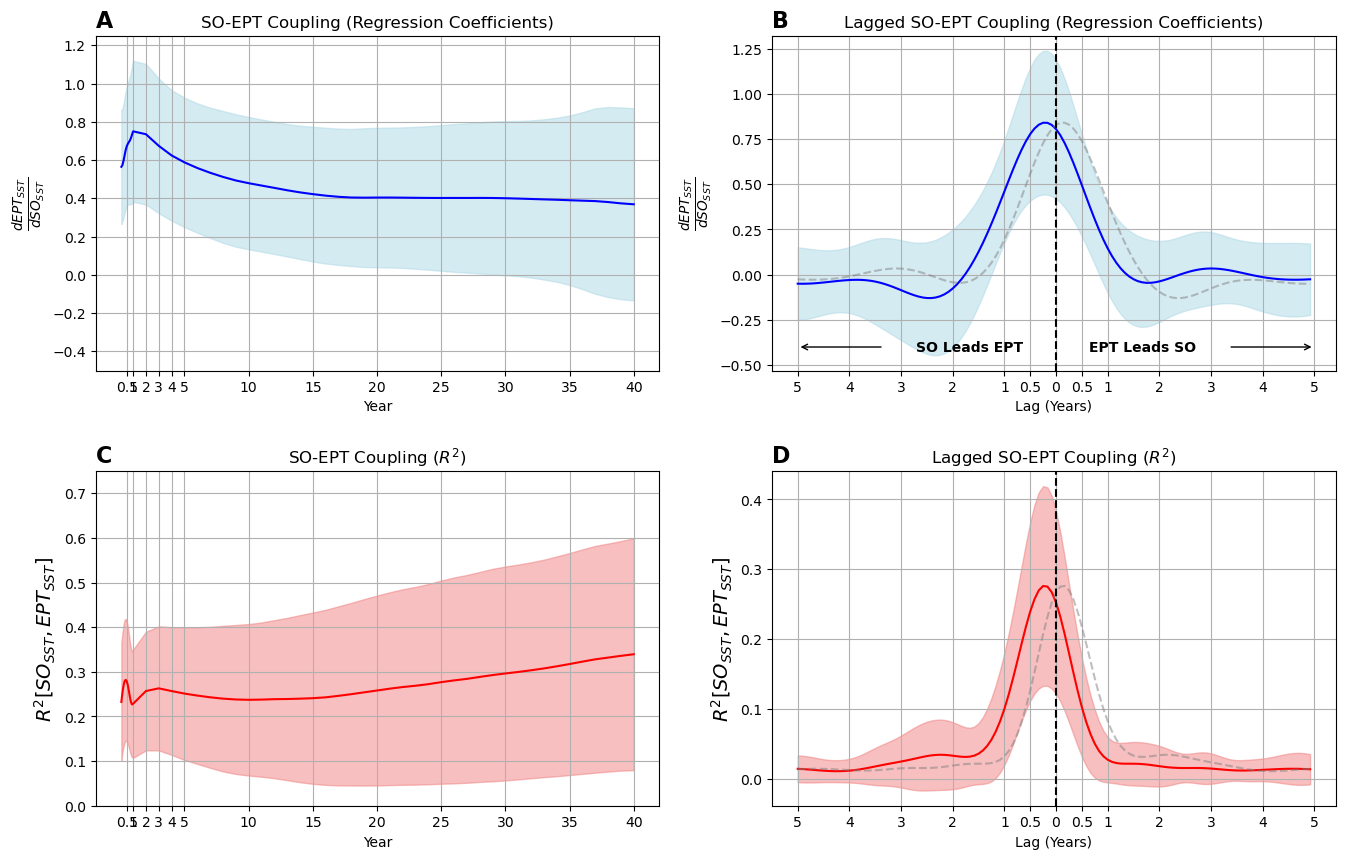

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Calculate the mean and standard deviation of rvalues_so_ept_coupling
mean_reg = rvalues_so_ept_coupling["reg"].mean(dim='model')
std_reg = rvalues_so_ept_coupling["reg"].std(dim='model')

mean_rvalues = (rvalues_so_ept_coupling["rvalues"]**2).mean(dim='model')
std_rvalues = (rvalues_so_ept_coupling["rvalues"]**2).std(dim='model')

# Calculate the upper and lower bounds for shading
upper_bound_reg = mean_reg + 1 * std_reg
lower_bound_reg = mean_reg - 1 * std_reg

upper_bound_rvalues = mean_rvalues + 1 * std_rvalues
lower_bound_rvalues = mean_rvalues - 1 * std_rvalues


# Plot rvalues_so_ept_coupling
axs[0, 0].plot(rvalues_so_ept_coupling.years, mean_reg, color='blue', label='Mean')
axs[0, 0].fill_between(rvalues_so_ept_coupling.years, lower_bound_reg, upper_bound_reg, color='lightblue', alpha=0.5, label='2-sigma')
axs[0, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
axs[0, 0].set_ylim(-.5, 1.25)
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 0].set_title(r'SO-EPT Coupling (Regression Coefficients)')
axs[0, 0].grid()

# Plot lag_so_ept_coupling
axs[0, 1].plot(lags, lagged_so_ept_coupling["reg"].mean(dim='model'), color='blue', label='Model Mean')
# reverse lagged_so_ept_coupling
reversed_lagged_so_ept_coupling = lagged_so_ept_coupling["reg"].mean(dim='model').values[::-1]
axs[0, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[0, 1].fill_between(lags, lagged_so_ept_coupling["reg"].mean(dim='model') - lagged_so_ept_coupling["reg"].std(dim='model'), lagged_so_ept_coupling["reg"].mean(dim='model') + lagged_so_ept_coupling["reg"].std(dim='model'), color='lightblue', alpha=0.5, label='2-sigma')
axs[0, 1].set_xlabel('Lag (Years)')
axs[0, 1].set_ylabel(r'$\frac{d EPT_{SST}}{d SO_{SST}}$', fontsize=14)
axs[0, 1].set_title('Lagged SO-EPT Coupling (Regression Coefficients)')
axs[0, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[0, 1].grid()

# Add text below x axis with arrows
axs[0, 1].text(-20, -0.4, "SO Leads EPT", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(-60, -0.4), xytext=(-40, -0.4), arrowprops=dict(arrowstyle="->"))
axs[0, 1].text(20, -0.4, "EPT Leads SO", ha='center', va='center', fontweight="bold") #, fontsize=axis_fontsize)
axs[0, 1].annotate("", xy=(60, -0.4), xytext=(40, -0.4), arrowprops=dict(arrowstyle="->"))

# Add vertical line at 0
axs[0, 1].axvline(0, color='black', linestyle='--')

# Plot rvalues_so_ept_coupling
axs[1, 0].plot(rvalues_so_ept_coupling.years, mean_rvalues, color='red', label='Mean')
axs[1, 0].fill_between(rvalues_so_ept_coupling.years, lower_bound_rvalues, upper_bound_rvalues, color='lightcoral', alpha=0.5, label='2-sigma')
axs[1, 0].set_xticks([6, 12, 24, 36, 48, *years[::-5]], labels=[.5, 1, 2, 3, 4, *np.arange(min_year, max_year+1)[::-5]])
axs[1, 0].set_ylim(0, .75)
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 0].set_title(r'SO-EPT Coupling ($R^2$)')
axs[1, 0].grid()

# Plot lagged_so_ept_coupling
axs[1, 1].plot(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') , color='red', label='Mean')
axs[1, 1].fill_between(lags, (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') - (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model') + (lagged_so_ept_coupling["rvalues"]**2).std(dim='model'), color='lightcoral', alpha=0.5, label='2-sigma')
reversed_lagged_so_ept_coupling = (lagged_so_ept_coupling["rvalues"]**2).mean(dim='model').values[::-1]
axs[1, 1].plot(lags, reversed_lagged_so_ept_coupling, color='gray', linestyle='--', alpha=0.5, label="Mirrored")
axs[1, 1].set_xlabel('Lag (Years)')
axs[1, 1].set_xticks([-60, -48, -36, -24, -12, -6, 0, 6, 12, 24, 36, 48, 60], labels=[5, 4, 3, 2, 1, .5, 0, .5, 1, 2, 3, 4, 5])
axs[1, 1].set_ylabel(r'$R^2[SO_{SST}, EPT_{SST}]$', fontsize=14)
axs[1, 1].set_title('Lagged SO-EPT Coupling ($R^2$)')
axs[1, 1].grid()
axs[1, 1].axvline(0, color='black', linestyle='--')

axs[0, 0].set_title('A', loc="left", fontweight="bold", fontsize=16)
axs[0, 1].set_title('B', loc="left", fontweight="bold", fontsize=16)
axs[1, 0].set_title('C', loc="left", fontweight="bold", fontsize=16)
axs[1, 1].set_title('D', loc="left", fontweight="bold", fontsize=16)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3) #, wspace=0.3)

# Show the plot
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/so_ept_coupling_lagged_and_timescale.png")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/so_ept_coupling_lagged_and_timescale.pdf")

# SO Cooling Characterstics
Plot regression coeffs between Southern Ocean/EPT and every other point.

In [ ]:
def get_region_reg(cmip_region_ssts, cmip_regressor, window: float = 12*5):
    ts_region_ssts = get_rolling_timeseries(cmip_region_ssts, window=window, step=12, gradient=False)
    ts_cmip_reg = get_rolling_timeseries(cmip_regressor, window=window, step=12, gradient=False)

    ts_cmip_reg, ts_region_ssts = get_shared_models(ts_cmip_reg, ts_region_ssts)
    reg_sst = xscore.linslope(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)

    pvalues_sst = xscore.pearson_r_eff_p_value(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)
    pvalues_models = (pvalues_sst < .05).sum(dim="model") < ts_region_ssts.model.size/2 # This evaluates to 1 if more than half modes are sig

    return reg_sst, pvalues_models

window=12*5

In [ ]:
if not os.path.exists("Data/reg_so_dataset.nc"):
    # Merge all reg_so_ and p_so_ values into a single dataset
    reg_so_sst, p_so_sst = get_region_reg(cmip_so_ssts, cmip_ssts["tos"], window=window)
    reg_so_pr, p_so_pr = get_region_reg(cmip_so_ssts, fix_coords(pr_cmip)["pr"], window=window)
    reg_so_psl, p_so_psl = get_region_reg(cmip_so_ssts, psl_cmip["psl"], window=window)
    reg_so_uas, p_so_uas = get_region_reg(cmip_so_ssts, cmip_monthly_uas["uas"], window=window)
    reg_so_vas, p_so_vas = get_region_reg(cmip_so_ssts, cmip_monthly_vas["vas"], window=window)
    reg_so_swcre, p_so_swcre = get_region_reg(cmip_so_ssts, cmip_monthly_swcre["swcre"], window=window)
    reg_so_lwcre, p_so_lwcre = get_region_reg(cmip_so_ssts, cmip_monthly_lwcre["lwcre"], window=window)
    reg_so_cre, p_so_cre = get_region_reg(cmip_so_ssts, cmip_monthly_lwcre["lwcre"] + cmip_monthly_swcre["swcre"], window=window)
    reg_so_dataset = xr.Dataset({
        'reg_so_sst': reg_so_sst,
        'p_so_sst': p_so_sst,
        'reg_so_pr': reg_so_pr,
        'p_so_pr': p_so_pr,
        'reg_so_psl': reg_so_psl,
        'p_so_psl': p_so_psl,
        'reg_so_uas': reg_so_uas,
        'p_so_uas': p_so_uas,
        'reg_so_vas': reg_so_vas,
        'p_so_vas': p_so_vas,
        'reg_so_swcre': reg_so_swcre,
        'p_so_swcre': p_so_swcre,
        'reg_so_lwcre': reg_so_lwcre,
        'p_so_lwcre': p_so_lwcre,
        'reg_so_cre': reg_so_cre,
        'p_so_cre': p_so_cre
    })

    # Save the merged dataset to a NetCDF file
    reg_so_dataset.to_netcdf('Data/reg_so_dataset.nc')
else: 
    reg_so_dataset = xr.open_dataset("Data/reg_so_dataset.nc")


In [18]:
if not os.path.exists("Data/reg_ept_dataset.nc"):
    # Merge all reg_so_ and p_so_ values into a single dataset
    reg_ept_sst, p_ept_sst = get_region_reg(cmip_ept_ssts, cmip_ssts["tos"], window=window)
    reg_ept_pr, p_ept_pr = get_region_reg(cmip_ept_ssts, fix_coords(pr_cmip)["pr"], window=window)
    reg_ept_psl, p_ept_psl = get_region_reg(cmip_ept_ssts, psl_cmip["psl"], window=window)
    reg_ept_uas, p_ept_uas = get_region_reg(cmip_ept_ssts, cmip_monthly_uas["uas"], window=window)
    reg_ept_vas, p_ept_vas = get_region_reg(cmip_ept_ssts, cmip_monthly_vas["vas"], window=window)
    reg_ept_swcre, p_ept_swcre = get_region_reg(cmip_ept_ssts, cmip_monthly_swcre["swcre"], window=window)
    reg_ept_lwcre, p_ept_lwcre = get_region_reg(cmip_ept_ssts, cmip_monthly_lwcre["lwcre"], window=window)
    reg_ept_cre, p_ept_cre = get_region_reg(cmip_ept_ssts, cmip_monthly_lwcre["lwcre"] + cmip_monthly_swcre["swcre"], window=window)
    reg_ept_dataset = xr.Dataset({
        'reg_ept_sst': reg_ept_sst,
        'p_ept_sst': p_ept_sst,
        'reg_ept_pr': reg_ept_pr,
        'p_ept_pr': p_ept_pr,
        'reg_ept_psl': reg_ept_psl,
        'p_ept_psl': p_ept_psl,
        'reg_ept_uas': reg_ept_uas,
        'p_ept_uas': p_ept_uas,
        'reg_ept_vas': reg_ept_vas,
        'p_ept_vas': p_ept_vas,
        'reg_ept_swcre': reg_ept_swcre,
        'p_ept_swcre': p_ept_swcre,
        'reg_ept_lwcre': reg_ept_lwcre,
        'p_ept_lwcre': p_ept_lwcre,
        'reg_ept_cre': reg_ept_cre,
        'p_ept_cre': p_ept_cre
    })

    # Save the merged dataset to a NetCDF file
    reg_ept_dataset.to_netcdf('Data/reg_ept_dataset.nc')
else: 
    reg_ept_dataset = xr.open_dataset("Data/reg_ept_dataset.nc")


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_d

## Precip

In [85]:
reg_so_walker, p_so_walker = get_region_reg(cmip_so_ssts, walker_anomaly, window=window)
reg_so_walker = reg_so_walker*(1/100) # Pa -> hPa

reg_so_WE, p_so_WE = get_region_reg(cmip_so_ssts, WE_sst_anomaly, window=window)

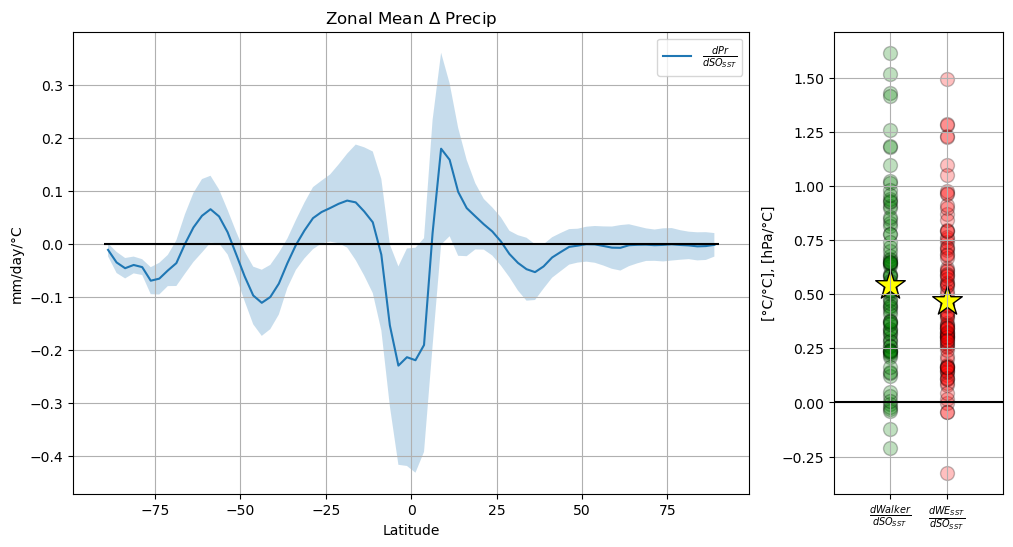

In [92]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Compute data
so_pr_mu = -reg_so_dataset["reg_so_pr"].mean(["model", "lon"]) * 86400
so_pr_std = -reg_so_dataset["reg_so_pr"].mean("lon").std(["model"]) * 86400
ept_pr_mu = -reg_ept_dataset["reg_ept_pr"].mean(["model", "lon"]) * 86400
ept_pr_std = -reg_ept_dataset["reg_ept_pr"].mean("lon").std(["model"]) * 86400

# Create a figure and define a GridSpec with two columns
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0.2)  # Main plot is 4x the width of the second plot

# Left subplot (main plot)
ax_main = fig.add_subplot(gs[0, 0])
so_pr_mu.plot(ax=ax_main, label=r"$\frac{dPr}{dSO_{SST}}$")
ax_main.fill_between(reg_so_dataset.lat, so_pr_mu + so_pr_std, so_pr_mu - so_pr_std, alpha=.25)
# Uncomment for ept data
# ept_pr_mu.plot(ax=ax_main, label=r"$\frac{dPr}{dEPT_{SST}}$")
# ax_main.fill_between(-reg_ept_dataset.lat, ept_pr_mu + ept_pr_std, ept_pr_mu - ept_pr_std, alpha=.25)

ax_main.grid()
ax_main.hlines(0, -90, 90, color="black")  # Hline at 0
ax_main.set_ylabel("mm/day/°C")
ax_main.set_xlabel("Latitude")
ax_main.legend()
ax_main.set_title(r"Zonal Mean $\Delta$ Precip")

# Right subplot (1/5th width)
ax_right = fig.add_subplot(gs[0, 1])
# Example data for the right subplot, replace with your specific needs
ax_right.scatter(np.zeros(len(reg_so_walker.model)), -reg_so_walker, alpha=.25, color="green", edgecolors="black", s=100)
ax_right.scatter(0, -reg_so_walker.mean("model"), edgecolors="black", color="yellow", marker="*", s=500)

ax_right.scatter(np.zeros(len(reg_so_WE.model)) + 1, -reg_so_WE, alpha=.25, color="red", edgecolors="black", s=100)
ax_right.scatter(1, -reg_so_WE.mean("model"), edgecolors="black", color="yellow", marker="*", s=500)

ax_right.set_xticks([0, 1])
ax_right.set_xlim(-1, 2)
ax_right.set_xticklabels([r"$\frac{dWalker}{dSO_{SST}}$", r"$\frac{dWE_{SST}}{dSO_{SST}}$"])
ax_right.set_ylabel("[°C/°C], [hPa/°C]")
ax_right.hlines(0, -1, 2, color="black")
ax_right.grid()

plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/zonal_mean_pr_walker_WE_response_so.png", dpi=300, bbox_inches="tight")

## Reg Maps

Text(0.0, 1.0, '5-year')

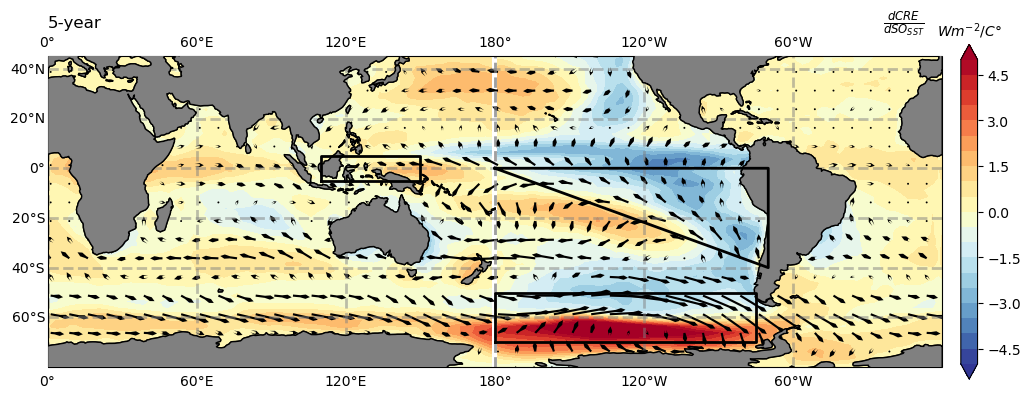

In [82]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=-(reg_so_lwcre.mean("model").values + reg_so_swcre.mean("model")),
    lat=reg_so_sst.lat,
    lon=reg_so_sst.lon,
    levels=np.arange(-5, 5.5, .5),
    # pvalues=pvalues_ept_sst,
    cmap="RdYlBu_r",
    wind={"uas": -reg_so_uas.mean("model").values, "vas": -reg_so_vas.mean("model").values},
    cbar_label=r"$Wm^{-2}/C\degree$",
)
ax1.set_title(r"$\frac{dCRE}{dSO_{SST}}$    ", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/cre_response_so.png", dpi=300, bbox_inches="tight")

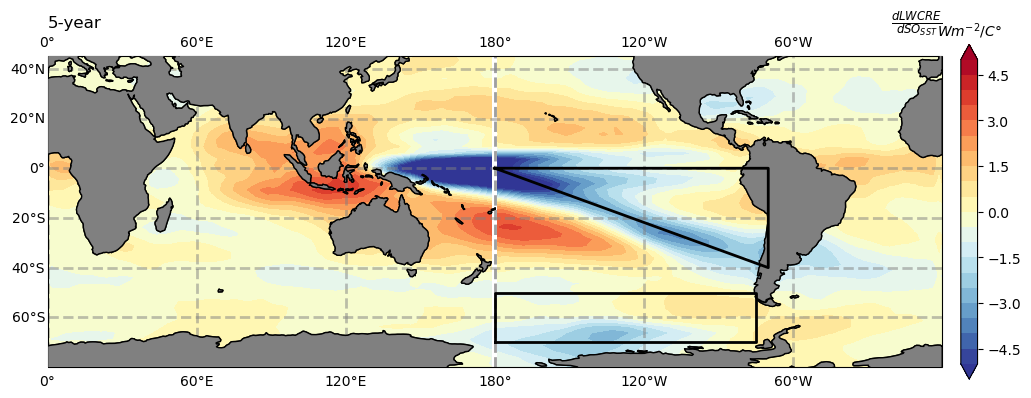

In [ ]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=-reg_so_lwcre.mean("model").values,
    lat=reg_so_sst.lat,
    lon=reg_so_sst.lon,
    levels=np.arange(-5, 5.5, .5),
    # pvalues=pvalues_ept_sst,
    cmap="RdYlBu_r",
    cbar_label=r"$Wm^{-2}/C\degree$",
)
ax1.set_title(r"$\frac{dLWCRE}{dSO_{SST}}$     ", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/lwcre_response_so.png", dpi=300, bbox_inches="tight")

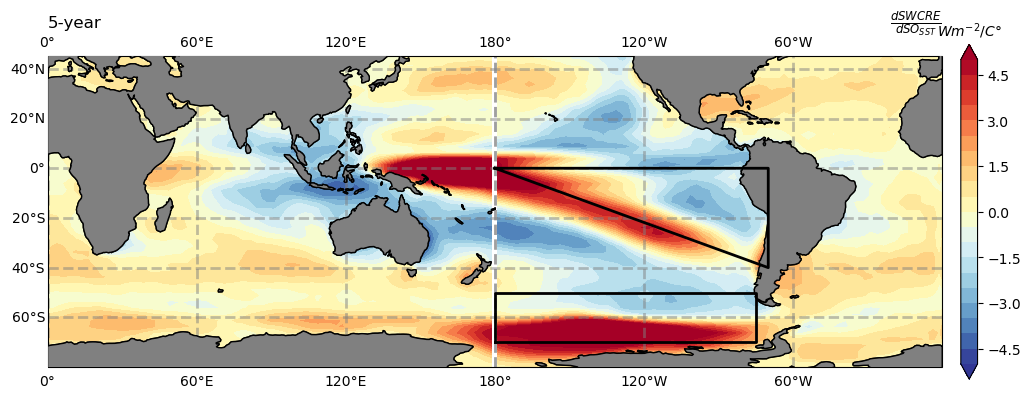

In [ ]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=-reg_so_swcre.mean("model").values,
    lat=reg_so_sst.lat,
    lon=reg_so_sst.lon,
    levels=np.arange(-5, 5.5, .5),
    # pvalues=pvalues_ept_sst,
    cmap="RdYlBu_r",
    cbar_label=r"$Wm^{-2}/C\degree$",
)
ax1.set_title(r"$\frac{dSWCRE}{dSO_{SST}}$     ", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcre_response_so.png", dpi=300, bbox_inches="tight")

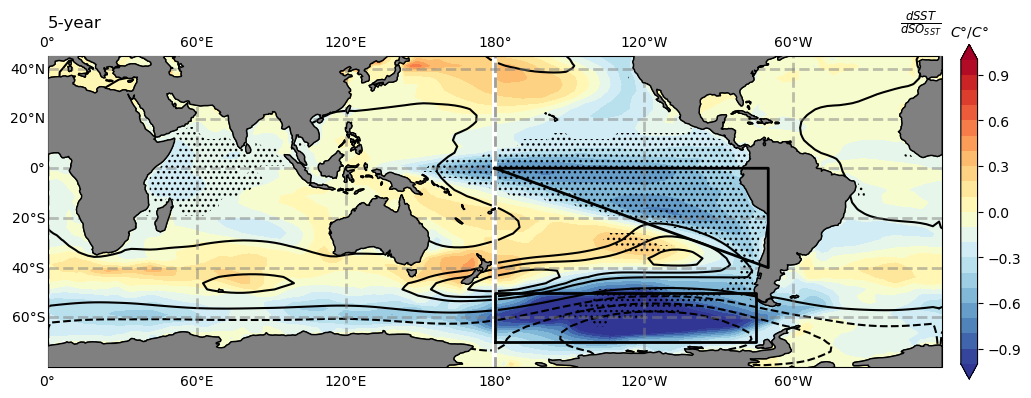

In [ ]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=-reg_so_sst.mean("model").values,
    lat=reg_so_sst.lat,
    lon=reg_so_sst.lon,
    levels=np.arange(-1, 1.1, .1),
    pvalues=pvalues_ept_sst,
    cmap="RdYlBu_r",
    cbar_label=r"$C\degree/C\degree$",
    contours=-reg_so_psl.mean("model").values,
)
ax1.set_title(r"$\frac{dSST}{dSO_{SST}}$     ", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_response_so.png", dpi=300, bbox_inches="tight")

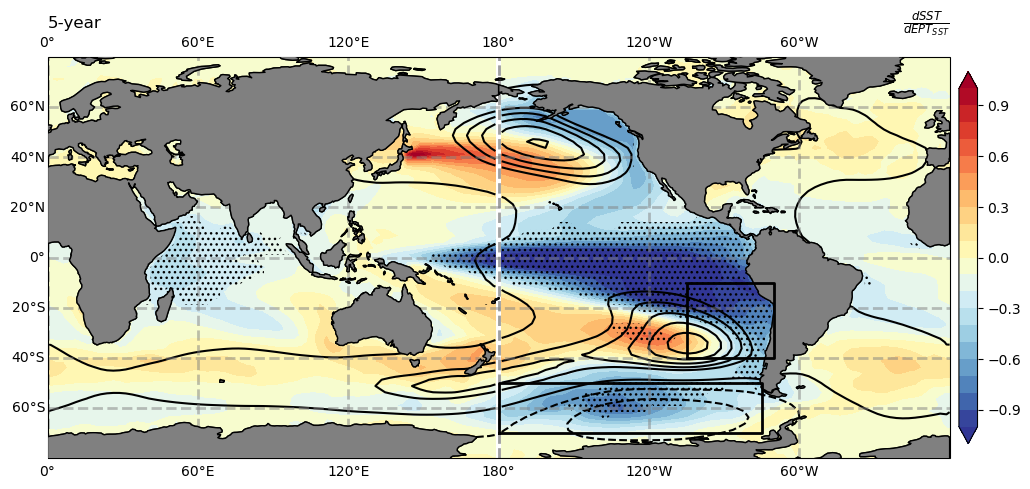

In [14]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=-reg_ept_sst.mean("model").values,
    lat=reg_ept_sst.lat,
    lon=reg_ept_sst.lon,
    levels=np.arange(-1, 1.1, .1),
    pvalues=pvalues_ept_sst,
    cmap="RdYlBu_r",
    cbar_label="K/30yr",
    contours=-reg_ept_psl.mean("model").values,
)
ax1.set_title(r"$\frac{dSST}{dEPT_{SST}}$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_response_ept.png", dpi=300, bbox_inches="tight")

In [60]:
std_so_ssts = ts_so_ssts.std("time")
std_ept_ssts = ts_ept_ssts.std("time")
std_cmip_ssts = ts_cmip_ssts.std("time")

std_cmip_ssts, std_so_ssts = get_shared_models(std_cmip_ssts, std_so_ssts)
std_cmip_ssts, std_ept_ssts = get_shared_models(std_cmip_ssts, std_ept_ssts)

r_so_ssts = xscore.pearson_r(std_so_ssts, std_cmip_ssts, dim="model", skipna=True)
r_ept_ssts = xscore.pearson_r(std_ept_ssts, std_cmip_ssts, dim="model", skipna=True)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


# Covariance Regions

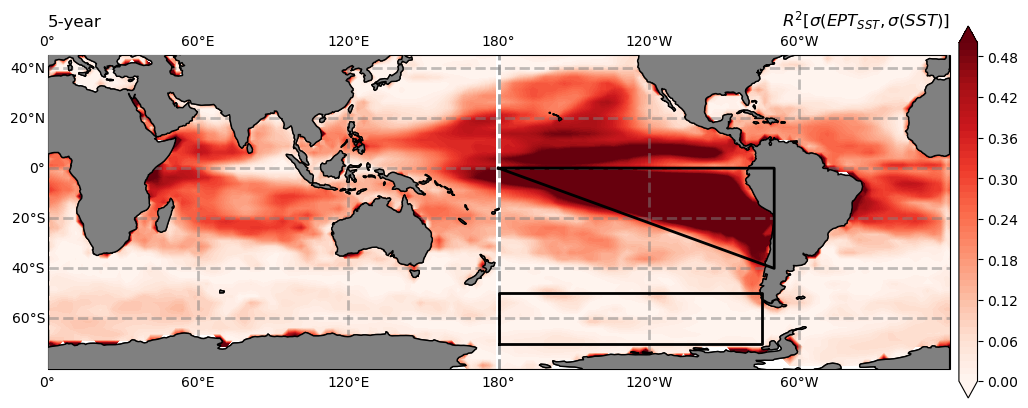

In [61]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=(r_ept_ssts**2).values,
    lat=r_ept_ssts.lat,
    lon=r_ept_ssts.lon,
    levels=np.arange(0, 0.51, .01),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\sigma(EPT_{SST}, \sigma(SST)]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_variance_ept.png", dpi=300, bbox_inches="tight")

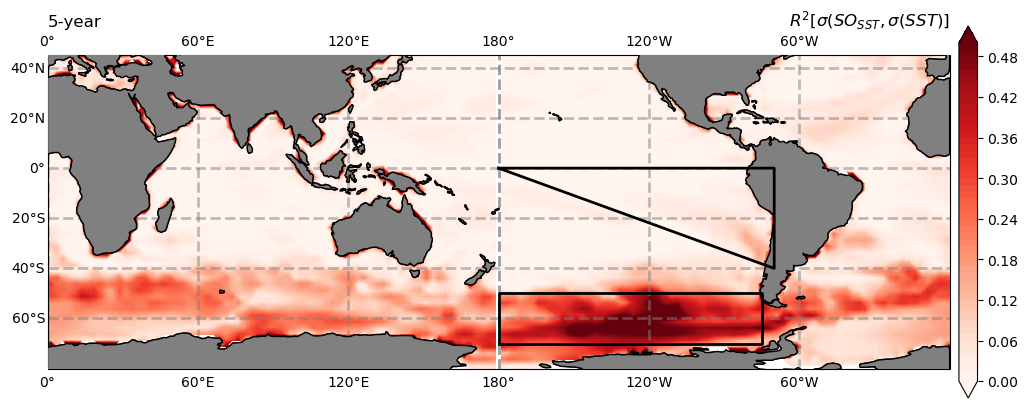

In [62]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=(r_so_ssts**2).values,
    lat=r_so_ssts.lat,
    lon=r_so_ssts.lon,
    levels=np.arange(0, 0.51, .01),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\sigma(SO_{SST}, \sigma(SST)]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_variance_so.png", dpi=300, bbox_inches="tight")

# Look at Asymmetry in Teleconnection - 1-sigma warm vs 1-sigma cold

In [63]:
ts_cmip_ssts_anoms = ts_cmip_ssts - ts_cmip_ssts.mean("time")

In [74]:
one_sigma_warming_mask = ts_so_ssts > (ts_so_ssts.mean("time") + ts_so_ssts.std("time"))
one_sigma_cooling_mask = ts_so_ssts < (ts_so_ssts.mean("time") - ts_so_ssts.std("time"))
sst_warming_map, sst_cooling_map = [], []
for model in ts_so_ssts.model:
    warm_mask = one_sigma_warming_mask.sel(model=model)
    cool_mask = one_sigma_cooling_mask.sel(model=model)

    sst_warming_map.append(ts_cmip_ssts_anoms.sel(model=model, time=ts_cmip_ssts_anoms.time[warm_mask]).mean("time"))
    sst_cooling_map.append(ts_cmip_ssts_anoms.sel(model=model, time=ts_cmip_ssts_anoms.time[cool_mask]).mean("time"))

sst_warming_map = xr.concat(sst_warming_map, dim="model")
sst_warming_map = sst_warming_map.mean("model")

sst_cooling_map = xr.concat(sst_cooling_map, dim="model")
sst_cooling_map = sst_cooling_map.mean("model")

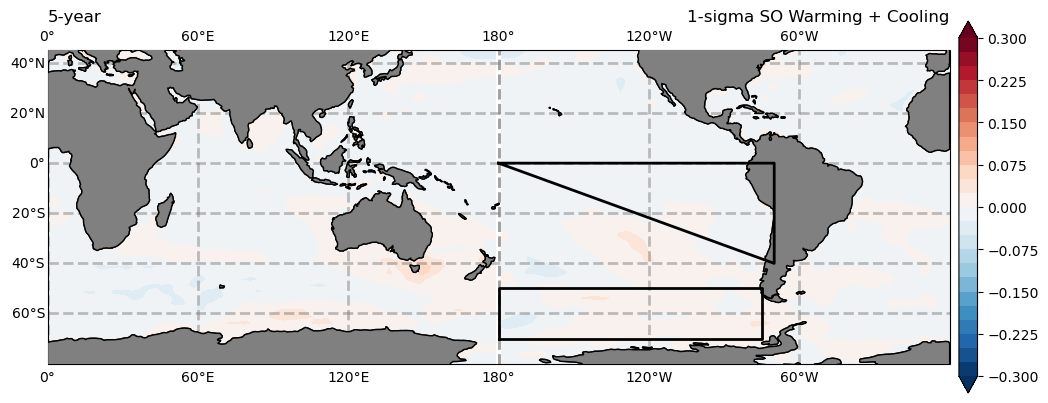

In [75]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_warming_map.values + sst_cooling_map.values,
    lat=sst_cooling_map.lat,
    lon=sst_cooling_map.lon,
    levels=np.arange(-.3, .325, .025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma SO Warming + Cooling", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_asymmetry_SO_same_scale.png", dpi=300, bbox_inches="tight")

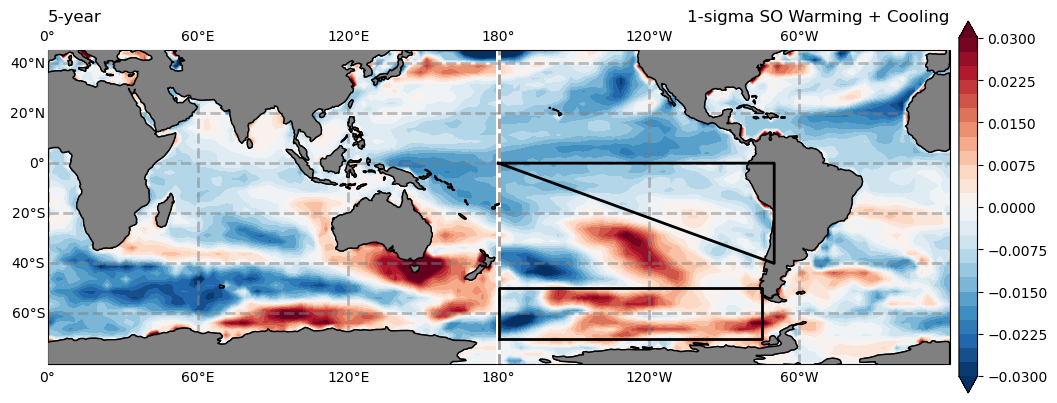

In [76]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_warming_map.values + sst_cooling_map.values,
    lat=sst_cooling_map.lat,
    lon=sst_cooling_map.lon,
    levels=np.arange(-.03, .0325, .0025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma SO Warming + Cooling", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_SO_asymmetrys.png", dpi=300, bbox_inches="tight")

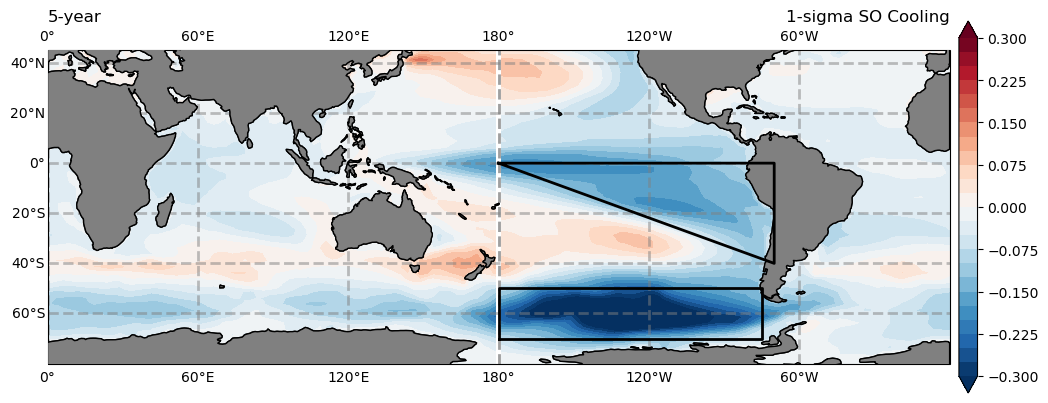

In [67]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_cooling_map.values,
    lat=sst_cooling_map.lat,
    lon=sst_cooling_map.lon,
    levels=np.arange(-.3, .325, .025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma SO Cooling", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_SO_cooling.png", dpi=300, bbox_inches="tight")

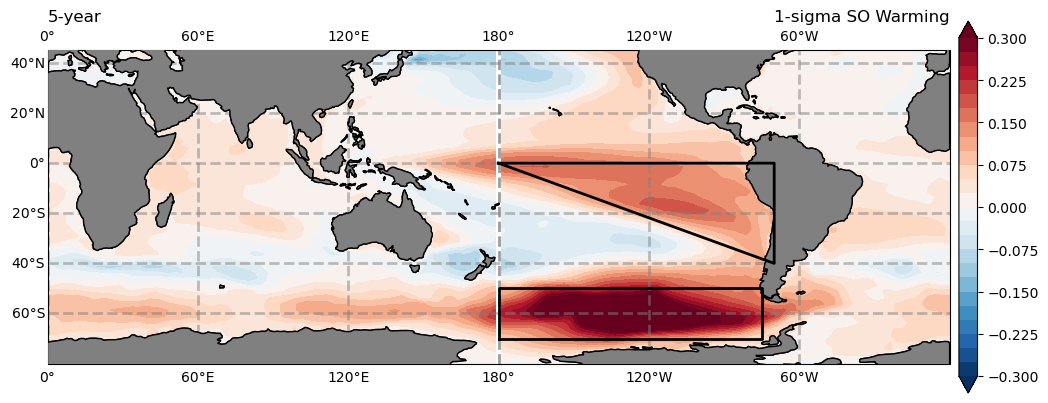

In [68]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_warming_map.values,
    lat=sst_warming_map.lat,
    lon=sst_warming_map.lon,
    levels=np.arange(-.3, .325, .025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma SO Warming", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_SO_warming.png", dpi=300, bbox_inches="tight")

In [69]:
one_sigma_warming_mask = ts_ept_ssts > (ts_ept_ssts.mean("time") + ts_ept_ssts.std("time"))
one_sigma_cooling_mask = ts_ept_ssts < (ts_ept_ssts.mean("time") - ts_ept_ssts.std("time"))
sst_warming_map, sst_cooling_map = [], []
for model in ts_ept_ssts.model:
    try: 
        warm_mask = one_sigma_warming_mask.sel(model=model)
        cool_mask = one_sigma_cooling_mask.sel(model=model)

        sst_warming_map.append(ts_cmip_ssts_anoms.sel(model=model, time=ts_cmip_ssts_anoms.time[warm_mask]).mean("time"))
        sst_cooling_map.append(ts_cmip_ssts_anoms.sel(model=model, time=ts_cmip_ssts_anoms.time[cool_mask]).mean("time"))
    except:
        print(model)

sst_warming_map = xr.concat(sst_warming_map, dim="model")
sst_warming_map = sst_warming_map.mean("model")

sst_cooling_map = xr.concat(sst_cooling_map, dim="model")
sst_cooling_map = sst_cooling_map.mean("model")

<xarray.DataArray 'model' ()>
array('E3SM-1-1-ECA', dtype='<U12')
Coordinates:
    model    <U12 'E3SM-1-1-ECA'


<xarray.DataArray 'model' ()>
array('NorESM2-LM', dtype='<U10')
Coordinates:
    model    <U10 'NorESM2-LM'
<xarray.DataArray 'model' ()>
array('FIO-ESM-2-0', dtype='<U11')
Coordinates:
    model    <U11 'FIO-ESM-2-0'
<xarray.DataArray 'model' ()>
array('HadGEM2-ES', dtype='<U10')
Coordinates:
    model    <U10 'HadGEM2-ES'
<xarray.DataArray 'model' ()>
array('MIROC5', dtype='<U6')
Coordinates:
    model    <U6 'MIROC5'


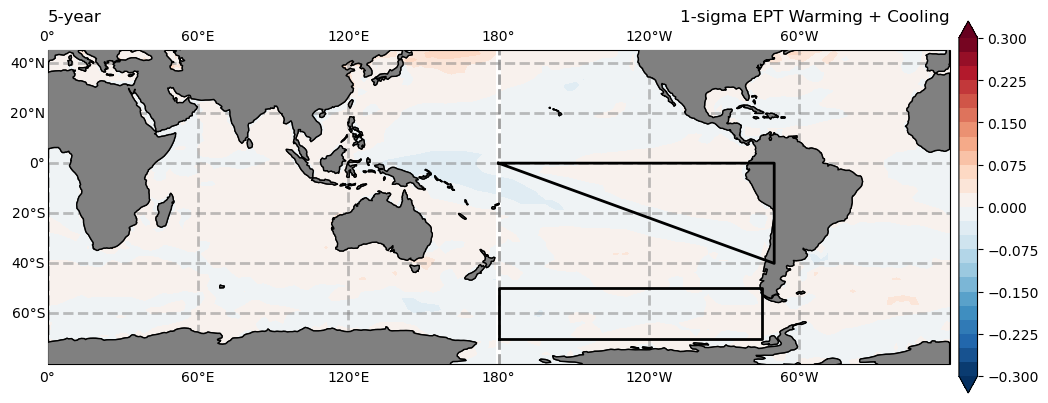

In [70]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_warming_map.values + sst_cooling_map.values,
    lat=sst_cooling_map.lat,
    lon=sst_cooling_map.lon,
    levels=np.arange(-.3, .325, .025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma EPT Warming + Cooling", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_asymmetry_EPT_same_scale.png", dpi=300, bbox_inches="tight")

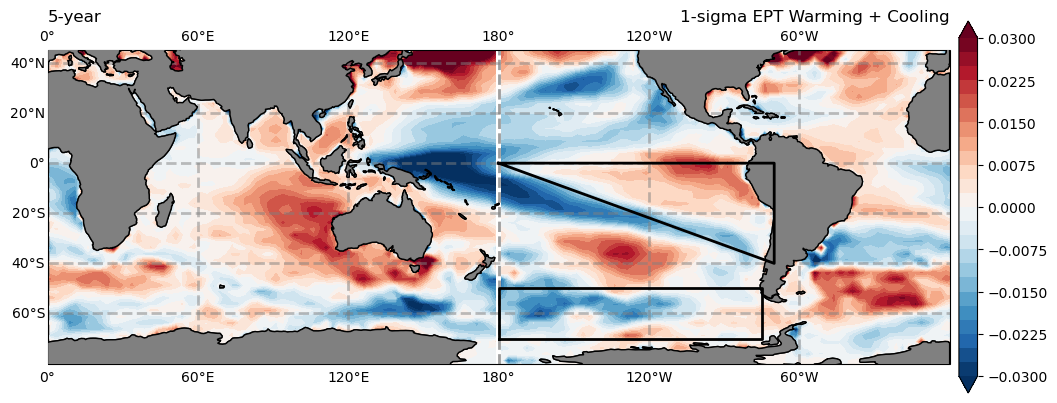

In [71]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_warming_map.values + sst_cooling_map.values,
    lat=sst_cooling_map.lat,
    lon=sst_cooling_map.lon,
    levels=np.arange(-.03, .0325, .0025),
    # levels=np.arange(-.15, .175, .025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma EPT Warming + Cooling", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_EPT_asymmetrys.png", dpi=300, bbox_inches="tight")

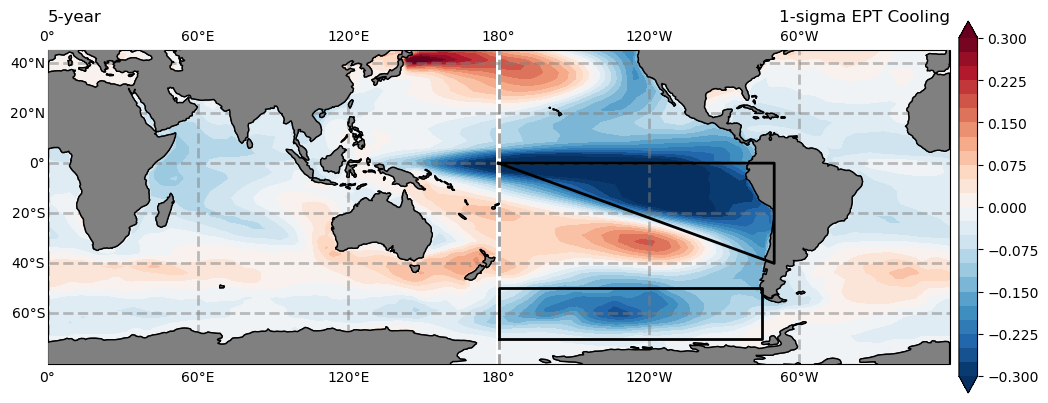

In [72]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_cooling_map.values,
    lat=sst_cooling_map.lat,
    lon=sst_cooling_map.lon,
    levels=np.arange(-.3, .325, .025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma EPT Cooling", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_EPT_cooling.png", dpi=300, bbox_inches="tight")

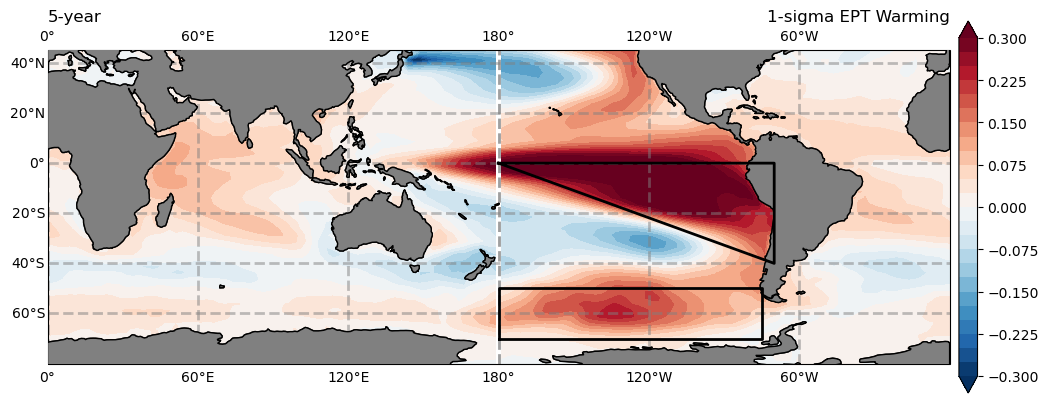

In [73]:

fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=sst_warming_map.values,
    lat=sst_warming_map.lat,
    lon=sst_warming_map.lon,
    levels=np.arange(-.3, .325, .025),
    cmap="RdBu_r",
    cbar_label="K/30yr"
)
ax1.set_title(r"1-sigma EPT Warming", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/1_sigma_EPT_warming.png", dpi=300, bbox_inches="tight")

# SO-EPT Coupling Explained by SWCF, Climatological Trades, and WES

## SWCF

In [15]:
def make_cyclic(ds):
    ds_end = ds.isel(lon=-1)
    ds_end["lon"] = 180
    ds_beg = ds.isel(lon=0)
    ds_beg["lon"] = -180
    ds_beg
    ds = xr.concat([ds_beg, ds, ds_end], dim="lon")
    return ds

rvalues_so_ept_coupling, swcf_cmip = get_shared_models(rvalues_so_ept_coupling, swcf_cmip)
r = xscore.pearson_r(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)
p = xscore.pearson_r_eff_p_value(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip["swcf"], dim="model", skipna=True)

r2 = make_cyclic(r**2)
p = make_cyclic(p)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site

/tmp/ipykernel_359997/3132620415.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


Text(0.0, 1.0, '5-year')

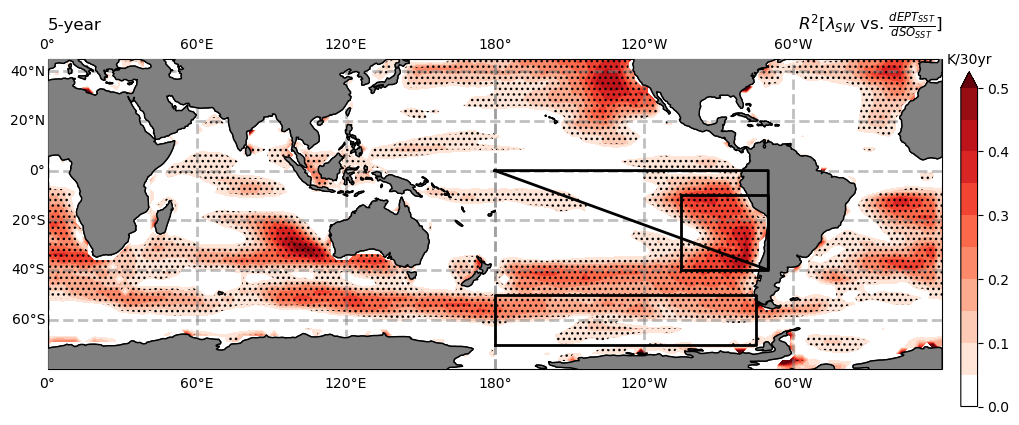

In [16]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2.values,
    pvalues=p,
    lat=r2.lat,
    lon=r2.lon,
    levels=np.arange(0, .55, .05),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\lambda_{SW}$ vs. $\frac{dEPT_{SST}}{dSO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
# cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
# plt.savefig("r2_swcf_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

## Trades

In [17]:
wind_speed = np.sqrt(cmip_monthly_vas["vas"]**2 + cmip_monthly_uas["uas"]**2)
wind_speed_clim = wind_speed.mean("time") # Climatological wind speed

rvalues_so_ept_coupling, wind_speed_clim = get_shared_models(rvalues_so_ept_coupling, wind_speed_clim)
r = xscore.pearson_r(rvalues_so_ept_coupling["reg"].sel(years=12*5), wind_speed_clim, dim="model", skipna=True)
p = xscore.pearson_r_eff_p_value(rvalues_so_ept_coupling["reg"].sel(years=12*5), wind_speed_clim, dim="model", skipna=True)

r2 = make_cyclic(r**2)
p = make_cyclic(p)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


/tmp/ipykernel_359997/3382312703.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


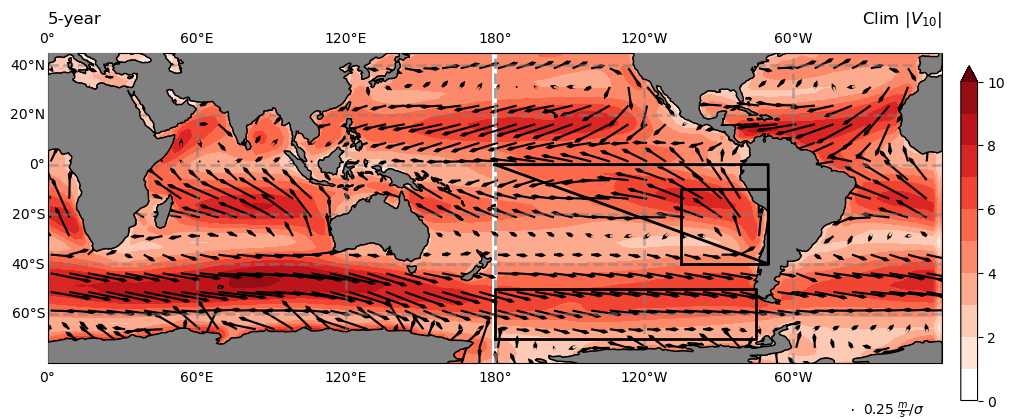

In [38]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=wind_speed_clim.mean("model").values,
    # pvalues=p,
    lat=wind_speed_clim.lat,
    lon=wind_speed_clim.lon,
    levels=np.arange(-0, 11, 1),
    cmap="Reds",
    wind={"uas": cmip_monthly_uas["uas"].mean(["model", "time"]).values, "vas": cmip_monthly_vas["vas"].mean(["model", "time"]).values},
    cbar_label=""
)
ax1.set_title(r"Clim $|V_{10}|$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
plt.savefig("clim_windspeed.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_359997/3132620415.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


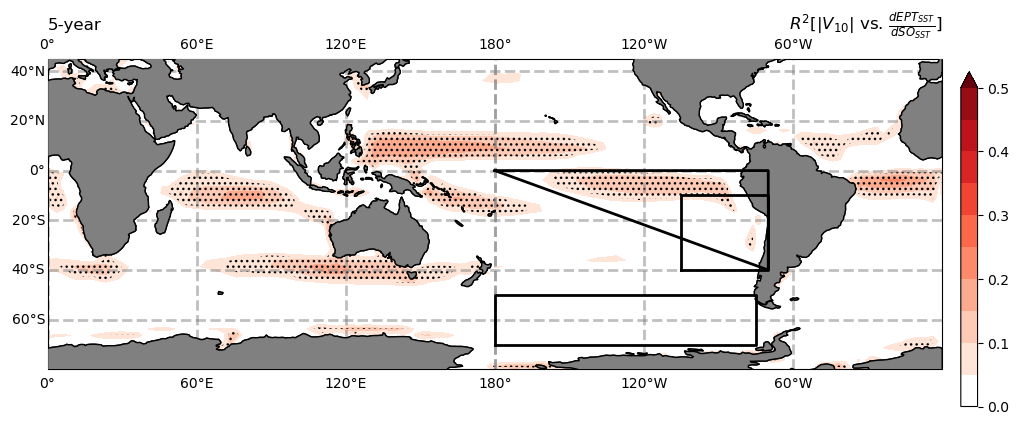

In [18]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2.values,
    pvalues=p,
    lat=r2.lat,
    lon=r2.lon,
    levels=np.arange(0, .55, .05),
    cmap="Reds",
    cbar_label=""
)
ax1.set_title(r"$R^2[|V_{10}|$ vs. $\frac{dEPT_{SST}}{dSO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
plt.savefig("r2_clim-windspeed_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

## WES

In [20]:
cmip_ssts, wind_speed = get_shared_models(cmip_ssts, wind_speed)
wes_fb = xscore.linslope(cmip_ssts["tos"], wind_speed, dim="time")
rvalues_so_ept_coupling, wes_fb = get_shared_models(rvalues_so_ept_coupling, wes_fb)
r = xscore.pearson_r(rvalues_so_ept_coupling["reg"].sel(years=12*5), wes_fb, dim="model", skipna=True)
p = xscore.pearson_r_eff_p_value(rvalues_so_ept_coupling["reg"].sel(years=12*5), wes_fb, dim="model", skipna=True)

r2 = make_cyclic(r**2)
p = make_cyclic(p)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/si

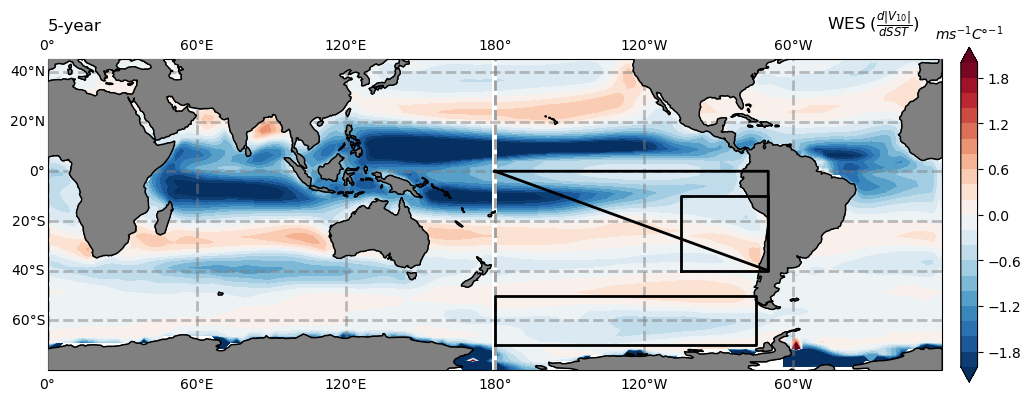

In [50]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=wes_fb.mean("model").values,
    # pvalues=p,
    lat=wes_fb.lat,
    lon=wes_fb.lon,
    levels=np.arange(-2, 2.2, .2),
    cmap="RdBu_r",
    # wind={"uas": cmip_monthly_uas["uas"].mean(["model", "time"]).values, "vas": cmip_monthly_vas["vas"].mean(["model", "time"]).values},
    cbar_label=r"$ms^{-1}C\degree^{-1}$"
)
ax1.set_title(r"WES ($\frac{d |V_{10}|}{d SST}$)     ",loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
plt.savefig("wes_fb_map.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_359997/3132620415.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


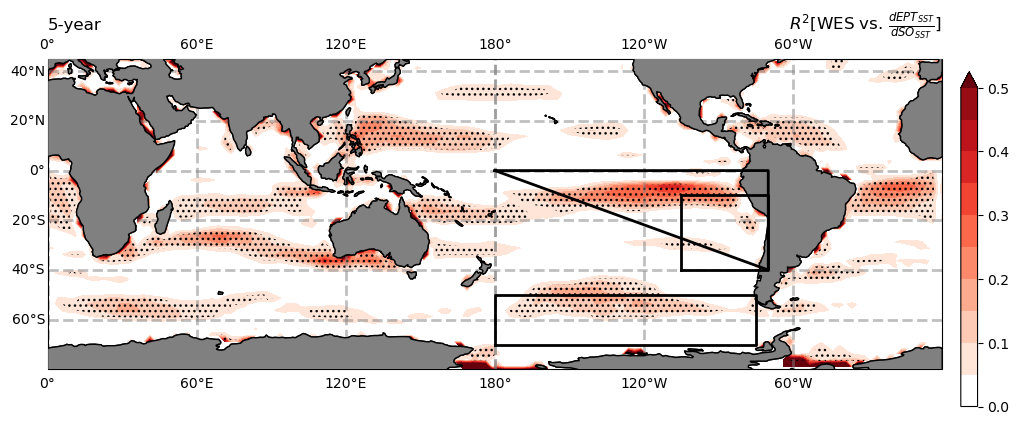

In [23]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2.values,
    pvalues=p,
    lat=r2.lat,
    lon=r2.lon,
    levels=np.arange(0, .55, .05),
    cmap="Reds",
    cbar_label=""
)
ax1.set_title(r"$R^2$[WES vs. $\frac{dEPT_{SST}}{dSO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
plt.savefig("r2_WES_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

# Repeat with Trends

In [14]:
so_ept_trend_coupling = xscore.linslope(sst_so_cmip, sst_ept_cmip, dim="time")
so_ept_trend_coupling, swcf_cmip = get_shared_models(so_ept_trend_coupling, swcf_cmip)
r2_trend = xscore.pearson_r(so_ept_trend_coupling, swcf_cmip["swcf"], dim="model", skipna=True)
p_trend = xscore.pearson_r_eff_p_value(so_ept_trend_coupling, swcf_cmip["swcf"], dim="model", skipna=True)

r2_trend = make_cyclic(r2_trend**2)
p_trend = make_cyclic(p_trend)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site

/tmp/ipykernel_234994/3600420704.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


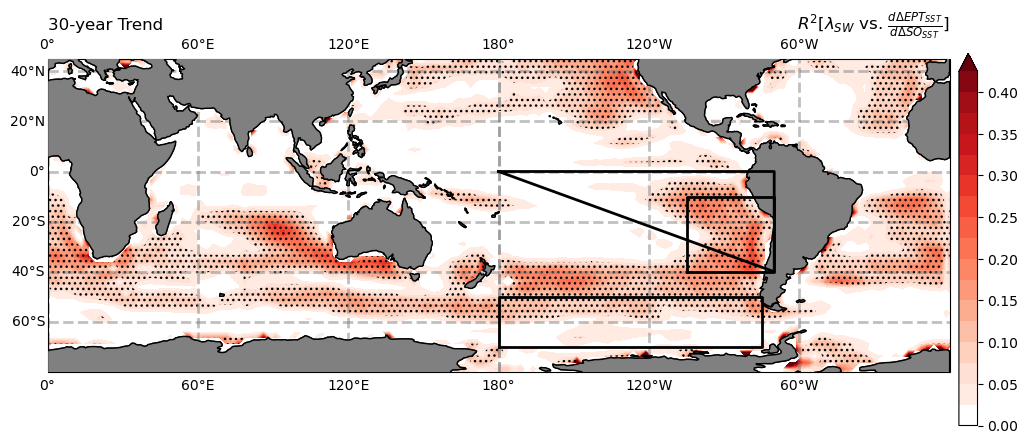

In [119]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2_trend.values,
    pvalues=p_trend,
    lat=r2_trend.lat,
    lon=r2_trend.lon,
    levels=np.arange(0, .450, .025),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\lambda_{SW}$ vs. $\frac{d \Delta EPT_{SST}}{d \Delta SO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"30-year Trend", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("r2_swcf_vs_ept-so-coupling_30year-trend.png", dpi=300, bbox_inches="tight")

In [27]:
cmip_ssts = xr.concat([cmip6_monthly_ssts.resample(time="5Y").mean(), cmip5_monthly_ssts.resample(time="5Y").mean()], dim="model")
cmip_ssts = cmip_ssts.std("time")


In [32]:
so_ept_trend_coupling = xscore.linslope(sst_so_cmip, sst_ept_cmip, dim="time")
so_ept_trend_coupling, cmip_ssts = get_shared_models(so_ept_trend_coupling, cmip_ssts)
r2_trend = xscore.pearson_r(so_ept_trend_coupling, cmip_ssts["tos"], dim="model", skipna=True)
p_trend = xscore.pearson_r_eff_p_value(so_ept_trend_coupling, cmip_ssts["tos"], dim="model", skipna=True)

r2_trend = make_cyclic(r2_trend**2)
p_trend = make_cyclic(p_trend)
r2_trend
p_trend

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site

<xarray.DataArray (lat: 72, lon: 146)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.80242965, 0.80242965, 0.78913696, ..., 0.80515357, 0.81166317,
        0.81166317],
       [0.88735189, 0.88735189, 0.89996423, ..., 0.87868844, 0.87660061,
        0.87660061],
       [0.84599424, 0.84599424, 0.84577752, ..., 0.85073642, 0.84068333,
        0.84068333]])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 -180.0 -178.8 -176.2 -173.8 ... 176.2 178.8 180.0

/tmp/ipykernel_870114/334533517.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


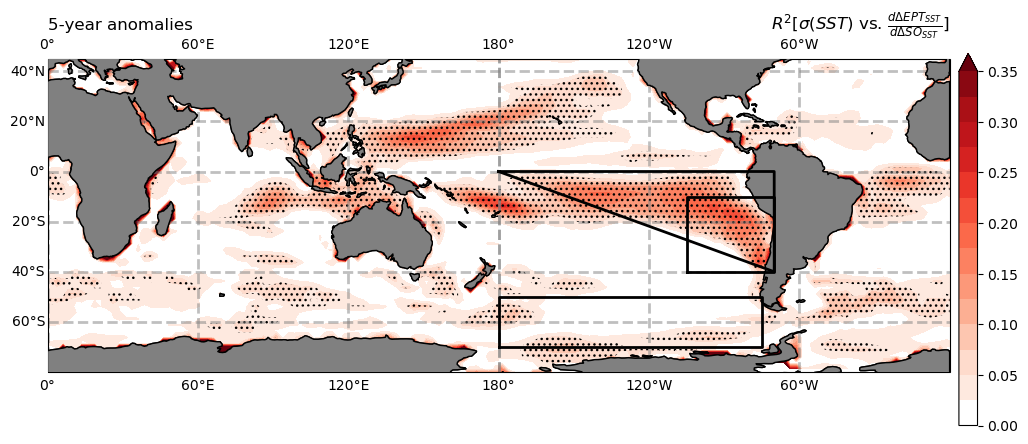

In [40]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r2_trend.values,
    pvalues=p_trend,
    lat=r2_trend.lat,
    lon=r2_trend.lon,
    levels=np.arange(0, .375, .025),
    cmap="Reds",
    cbar_label="K/30yr"
)
ax1.set_title(r"$R^2[\sigma(SST)$ vs. $\frac{d \Delta EPT_{SST}}{d \Delta SO_{SST}}]$", loc="right", fontsize=title_fontsize*.75)
ax1.set_title(r"5-year anomalies", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("r2_sst_variance_vs_ept-so-coupling_30year-trend.png", dpi=300, bbox_inches="tight")
plt.savefig("r2_sst_variance_vs_ept-so-coupling_30year-trend.pdf", dpi=300, bbox_inches="tight")

# Observations

In [32]:
SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE"]
obs_sst_regression = {}
for i, sst_product in enumerate(SST_PRODUCTS): 
    obs_sst = xr.open_dataset(f"/home/espinosa10/SO-EP-teleconnection/Data/obs/{sst_product}_sst_ept_so.nc")
    # Add dimension called model with value cobe to dataset
    obs_sst = obs_sst[['Raw_SO_Mean', 'Raw_EPT_Mean']]
    obs_sst = obs_sst.expand_dims("model")
    obs_sst["model"] = ["COBE"]

    obs_sst_reg = calculate_coupling_depending_on_time(obs_sst["Raw_SO_Mean"], obs_sst["Raw_EPT_Mean"], models=obs_sst.model)
    obs_sst_regression[sst_product] = obs_sst_reg
    print(sst_product)
    print(obs_sst_reg.sel(years=12*5).reg.values)
    print(obs_sst_reg.sel(years=12*5).rvalues.values)

NOAA-OISST-v2.1
[0.47729609]
[0.36560572]


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/pyth

PCMDI-AMIP-1-1-9
[1.22774301]
[0.59810875]


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/pyth

ERA5
[0.30080701]
[0.41703187]


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)


NOAA-ERSSTv5
[1.03283519]
[0.73885132]


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)


COBE
[1.93049793]
[0.88012625]


# Scatter Plots

0.572 0.0


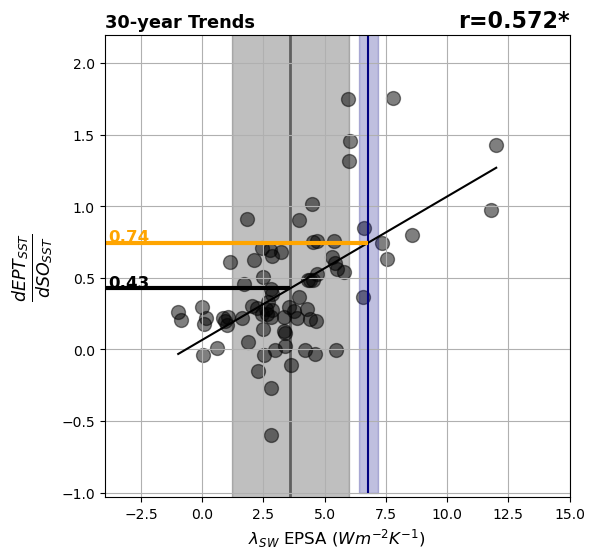

In [19]:
obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
axis_fontsize = 12
title_fontsize = 16
rval, swcf_cmip_epsa = get_shared_models(so_ept_trend_coupling, swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    rval.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("30-year Trends", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("line_swcf_vs_ept-so-coupling_30year-trend.png", dpi=300, bbox_inches="tight")

0.69 0.0
0.9938358465777275


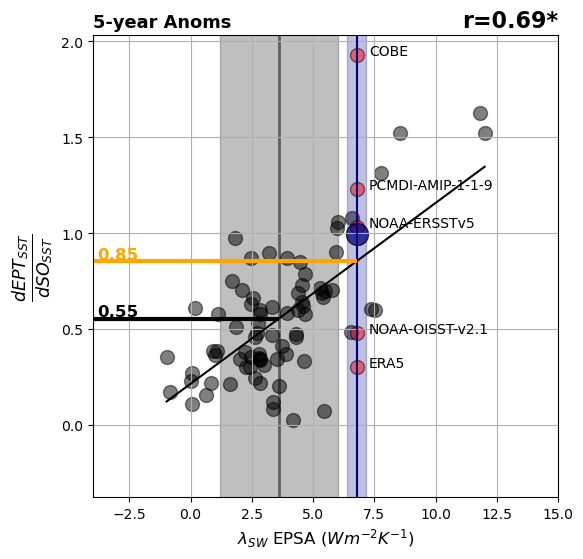

In [46]:
obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
rval, swcf_cmip_epsa = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    rval.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# Add one line per obs
obs_mean = []
for sst_product in SST_PRODUCTS:
    obs_coupling = obs_sst_regression[sst_product].sel(years=12*5).reg.values
    obs_mean.append(obs_coupling)
    ax.scatter(np.mean(obs_swcf), obs_coupling, s=100, alpha=.5, edgecolor="black", color="red")
    ax.text(s=sst_product, x=np.mean(obs_swcf) + .5, y=obs_coupling, color="black", fontsize=10) # Add text next to point with label

ax.scatter(np.mean(obs_swcf), np.mean(obs_mean), s=250, alpha=.75, edgecolor="black", color="navy", label="Obs Mean")
print(np.mean(obs_mean))
plt.savefig("line_swcf_vs_ept-so-coupling_5year_wObs.png", dpi=300, bbox_inches="tight")

In [202]:
for yr in rvalues_so_ept_coupling.years:
    rval, swcf_cmip_epsa = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=yr), swcf_cmip_epsa)
    reg = linregress(swcf_cmip_epsa.values, rval.values)
    print(yr.values, reg.rvalue)

1 0.3335879877840655
2 0.35523652187681676
3 0.37875696019743493
4 0.40805010654372514
5 0.4258656480796585
6 0.43692736496846835
7 0.4446804511001412
8 0.4513791134538648
9 0.45795332710261477
10 0.4658226975816101
11 0.47225897841076797
12 0.47604907898553156
24 0.535597875730509
36 0.6145834488979357
48 0.674080268432592
60 0.6901012804178418
72 0.6835311160506282
84 0.6770170271086582
96 0.6738825784569463
108 0.6628962094982154
120 0.6434514625274924
132 0.626460573847351
144 0.6126253087670269
156 0.5949457711166177
168 0.5749540802445993
180 0.556270486481433
192 0.5401414504111611
204 0.5226018621000794
216 0.5004628733728689
228 0.48063691410229936
240 0.4662042525078687
252 0.45208171802412384
264 0.43659874412069277
276 0.4219436629387629
288 0.40857401226235135
300 0.3941979467698298
312 0.3783753381049227
324 0.3613134487950956
336 0.34349328939700896
348 0.32597668253625933
360 0.3097201924668962
372 0.2953953361095201
384 0.2832313734231405
396 0.2705322902718002
408 0.2

# Examine Relationship between Internal Variability and Magnitude of Coupling

## Coupling vs. Variance EPT Ocean

0.752 0.0


Text(0.0, 1.0, '5-year Anoms')

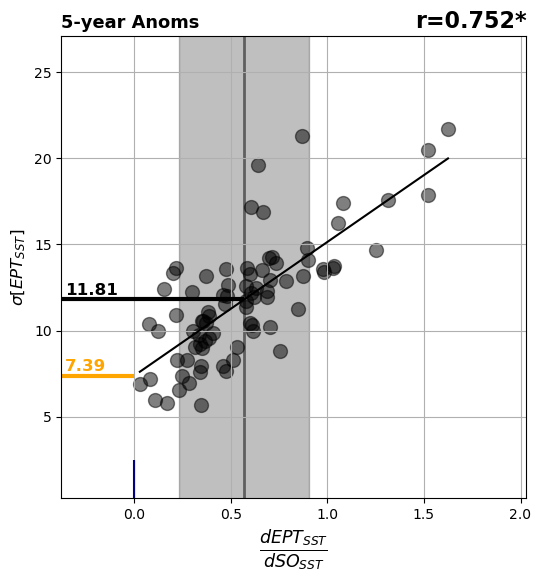

In [21]:
# Coupling vs. Variance SO
# for yr in rvalues_so_ept_coupling.years:
#     reg = linregress(rvalues_so_ept_coupling.reg.sel(years=yr), rvalues_so_ept_coupling.variance_ept.sel(years=yr))
#     print(yr.values, reg.rvalue)
yr = 12*5
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rvalues_so_ept_coupling.reg.sel(years=yr),
    rvalues_so_ept_coupling.variance_ept.sel(years=yr),
    vline=[0,0,0]
)
ax.grid()
ax.set_ylabel(r"$\sigma[EPT_{SST}]$", fontsize=axis_fontsize)
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept5yr_variance_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

## Coupling vs. Variance Southern Ocean

1 -0.2744688177261168
2 -0.26616098306063174
3 -0.26128477388778465
4 -0.2521471332223145
5 -0.23501902158836074
6 -0.21372473161831562
7 -0.20188087586985234
8 -0.19890860151174755
9 -0.2026638983904381
10 -0.20695477711111906
11 -0.20667782170794904
12 -0.20956943852907947
24 -0.2410498959757322
36 -0.2534064892073067
48 -0.2552462471358449
60 -0.25401654825753334
72 -0.25674731616260393
84 -0.2529180991988977
96 -0.24354110676520588
108 -0.239575502125111
120 -0.24107932667149062
132 -0.24097991963150428
144 -0.23415917632574615
156 -0.22275804948060776
168 -0.20919369591399134
180 -0.1973329426990992
192 -0.18869074834549715
204 -0.18244336942743347
216 -0.17918323674185982
228 -0.18068112461791522
240 -0.18586159776438893
252 -0.19153911849961386
264 -0.196323147560306
276 -0.19901951899516504
288 -0.1994739359379882
300 -0.20003630832020985
312 -0.20152561621796994
324 -0.2023465039044139
336 -0.20403718094179193
348 -0.2043058329998692
360 -0.20241935821350215
372 -0.19880104404

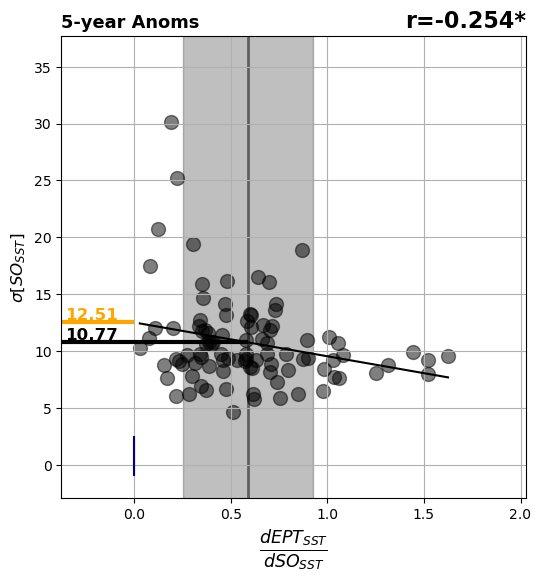

In [265]:
# Coupling vs. Variance SO
for yr in rvalues_so_ept_coupling.years:
    reg = linregress(rvalues_so_ept_coupling.reg.sel(years=yr), rvalues_so_ept_coupling.variance_so.sel(years=yr))
    print(yr.values, reg.rvalue)

yr = 12*5
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rvalues_so_ept_coupling.reg.sel(years=yr),
    rvalues_so_ept_coupling.variance_so.sel(years=yr),
    vline=[0,0,0]
)
ax.grid()
ax.set_ylabel(r"$\sigma[SO_{SST}]$", fontsize=axis_fontsize)
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/so5yr_variance_vs_ept-so-coupling_5year.png", dpi=300, bbox_inches="tight")

# Examine Relationship between Forced Response, Internal Variability, Coupling, and SWCF

My hunch is that the magnitude of the forced response in the Southern Ocean is related to the magnitude of the forced response in the EPT, such that models with amplified SO warming tend to have amplified EPT warming and vise versa. 
- The figure below seems to suggest that this is true but a weak constraint. 

In [ ]:
# Last 30 years
sst_cmip_4xc02_warm = sst_cmip_4xc02.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - sst_cmip_4xc02.isel(time=slice(0, 12*30)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 12*30)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 12*30)).mean(dim="time")["tos"]

sst_cmip_4xc02_norm = sst_cmip_4xc02_warm / global_warming
so_warming_norm = so_warming / global_warming

r = xscore.pearson_r(so_warming_norm, sst_cmip_4xc02_norm, dim="model", skipna=True)
reg = xscore.linslope(so_warming_norm, sst_cmip_4xc02_norm, dim="model", skipna=True)
p = xscore.pearson_r_eff_p_value(so_warming_norm, sst_cmip_4xc02_norm, dim="model", skipna=True)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/si

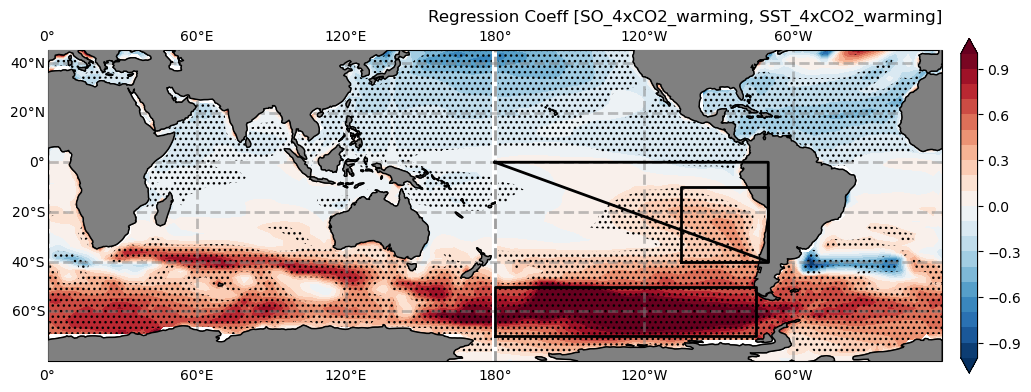

In [227]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=reg, 
    lat=reg.lat,
    lon=reg.lon,
    pvalues=p,
    cmap="RdBu_r",
    cbar_label="",
    levels=np.arange(-1, 1.1, .1)
)
ax1.set_title(r"Regression Coeff [SO_4xCO2_warming, SST_4xCO2_warming]", loc="right", fontsize=title_fontsize*.75)
# ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
# cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/SO_4xc02_warming_SST_4xc02_warming_reg.png", dpi=300, bbox_inches="tight")

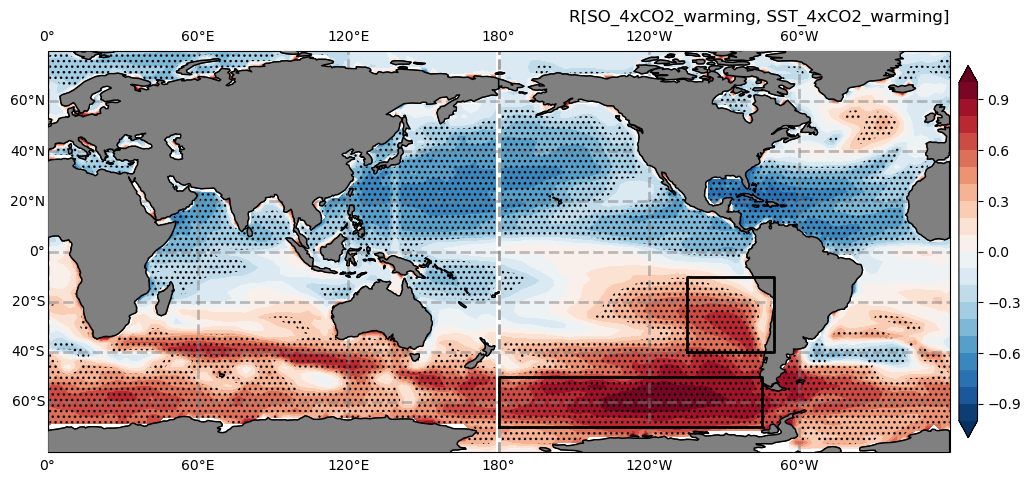

In [ ]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r, 
    lat=r.lat,
    lon=r.lon,
    pvalues=p,
    cmap="RdBu_r",
    cbar_label="K/30yr",
    levels=np.arange(-1, 1.1, .1)
)
ax1.set_title(r"R[SO_4xCO2_warming, SST_4xCO2_warming]", loc="right", fontsize=title_fontsize*.75)
# ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/SO_4xc02_warming_SST_4xc02_warming.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_4173823/610106800.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap(cmap)


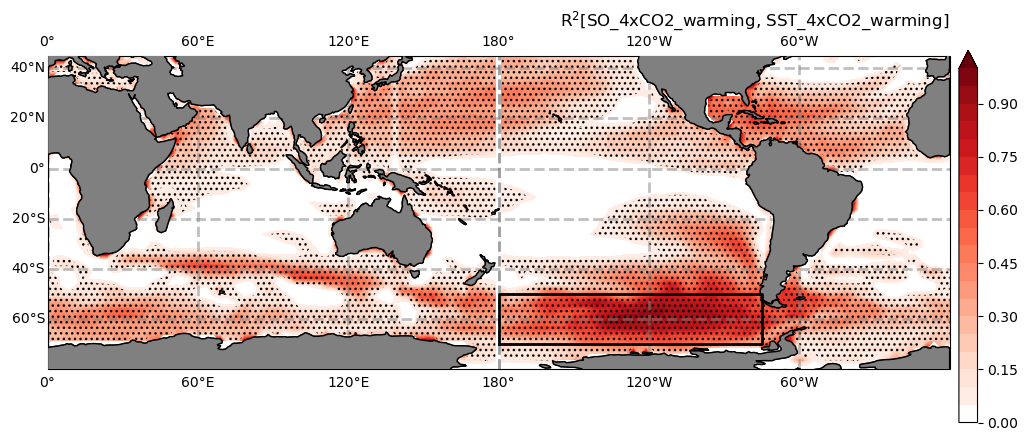

In [28]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r**2, 
    lat=r.lat,
    lon=r.lon,
    pvalues=p,
    cmap="Reds",
    cbar_label="K/30yr",
    levels=np.arange(0, 1.05, .05)
)
ax1.set_title(r"R$^2$[SO_4xCO2_warming, SST_4xCO2_warming]", loc="right", fontsize=title_fontsize*.75)
cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/R^2_SO_4xc02_warming_SST_4xc02_warming.png", dpi=300, bbox_inches="tight")

## Group by High and Low dEPT/dSO coupling and take difference
Group models with high coupling and low coupling. Then plot the difference between their normalized 

In [311]:
early_slice = slice(0, 12*20)
late_slice = slice(12*21, 12*150)
sst_cmip_4xc02_early = sst_cmip_4xc02.isel(time=early_slice)["tos"].resample(time="1Y").mean("time") #.mean(dim="time")["tos"]
sst_cmip_4xc02_late = sst_cmip_4xc02.isel(time=late_slice)["tos"].resample(time="1Y").mean("time") #.mean(dim="time")["tos"]
sst_cmip_4xc02_late = sst_cmip_4xc02.isel(time=late_slice)["tos"].resample(time="1Y").mean("time") #.mean(dim="time")["tos"]

global_cmip_4xc02_early = cmip_4xc02_global_sst.isel(time=early_slice)["tos"].resample(time="1Y").mean("time") #.mean(dim="time")["tos"]
global_cmip_4xc02_late = cmip_4xc02_global_sst.isel(time=late_slice)["tos"].resample(time="1Y").mean("time") #.mean(dim="time")["tos"]

# Group by models with high and low coupling
so_ept_coupling_5year = rvalues_so_ept_coupling.reg.sel(years=yr)
so_ept_coupling_5year, sst_cmip_4xc02 = get_shared_models(so_ept_coupling_5year, sst_cmip_4xc02)

global_cmip_4xc02_late = global_cmip_4xc02_late.sel(model=sst_cmip_4xc02.model)
global_cmip_4xc02_early = global_cmip_4xc02_early.sel(model=sst_cmip_4xc02.model)

bottom_half_coupling = so_ept_coupling_5year[so_ept_coupling_5year < so_ept_coupling_5year.median()]
top_half_coupling = so_ept_coupling_5year[so_ept_coupling_5year >= so_ept_coupling_5year.median()]

# Early Low Coupling
early_low = sst_cmip_4xc02_early.sel(model=bottom_half_coupling.model)
early_low = xscore.linslope(global_cmip_4xc02_early.sel(model=bottom_half_coupling.model), early_low, dim="time").mean("model")
# Early High Coupling
early_high = sst_cmip_4xc02_early.sel(model=top_half_coupling.model)
early_high = xscore.linslope(global_cmip_4xc02_early.sel(model=top_half_coupling.model), early_high, dim="time").mean("model")
# Late Low Coupling
late_low = sst_cmip_4xc02_late.sel(model=bottom_half_coupling.model)
late_low = xscore.linslope(global_cmip_4xc02_late.sel(model=bottom_half_coupling.model), late_low, dim="time").mean("model")
# Late High Coupling
late_high = sst_cmip_4xc02_late.sel(model=top_half_coupling.model)
late_high = xscore.linslope(global_cmip_4xc02_late.sel(model=top_half_coupling.model), late_high, dim="time").mean("model")

/tmp/ipykernel_359997/3849726901.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


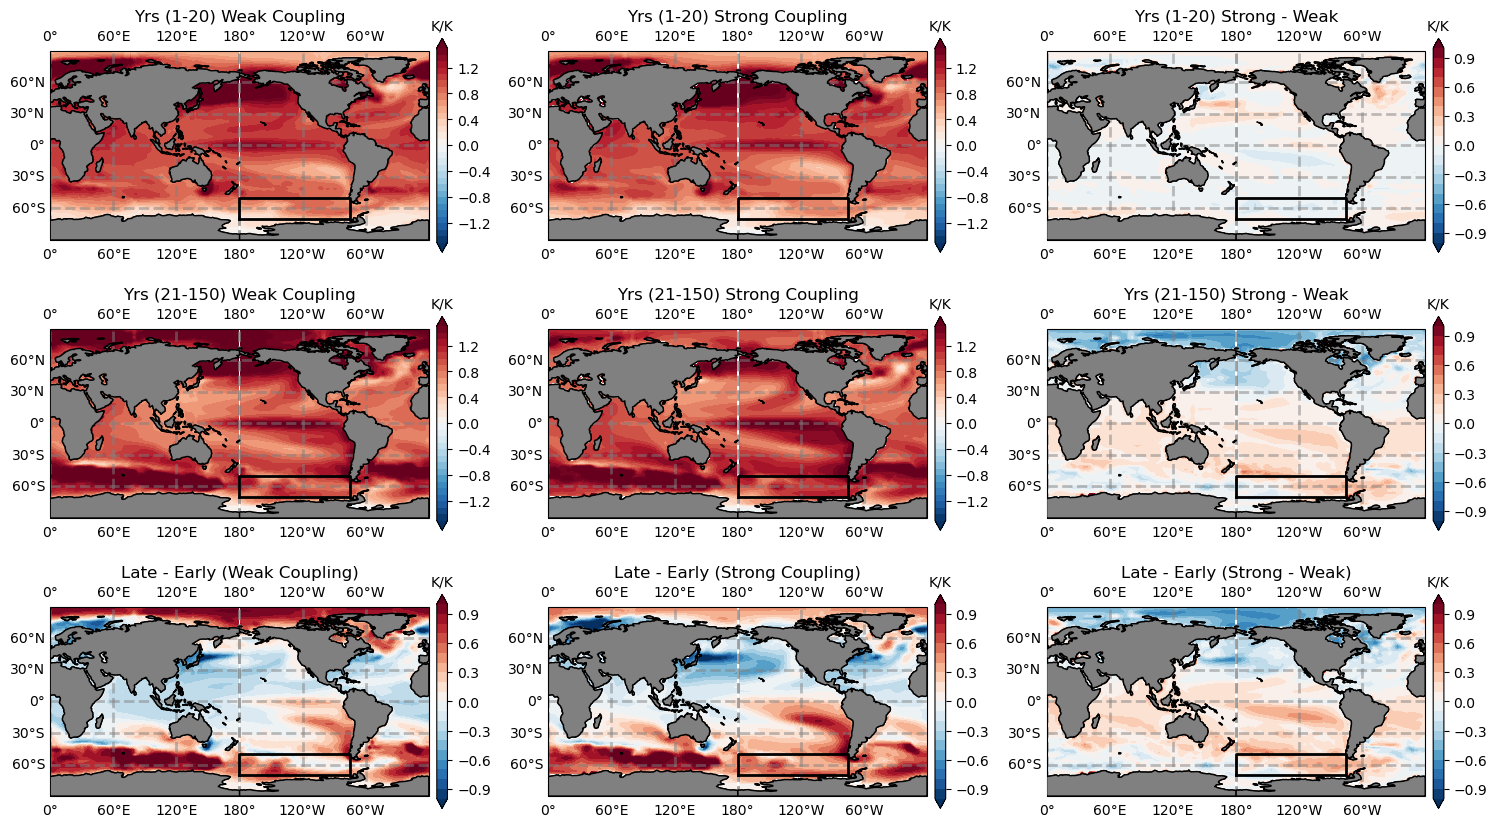

In [323]:
# Create a figure and define a GridSpec with three rows and three columns
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(3, 3, wspace=0.25, hspace=0.30)

# Define the levels and colormap for the plots
levels = np.arange(-2, 2.1, 0.1)
diff_levels = np.arange(-1, 1.1, 0.1)
warming_levels = np.arange(-1.5, 1.6, 0.1)
cmap = "RdBu_r"

# Plot early_low
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax1, data=early_low.values, lat=early_low.lat, lon=early_low.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax1.set_title(r"Yrs (1-20) Weak Coupling")

# Plot early_high
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax2, data=early_high.values, lat=early_high.lat, lon=early_high.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax2.set_title(r"Yrs (1-20) Strong Coupling")

# Plot difference between early_high and early_low
ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax3, data = (early_high - early_low).values, lat=early_low.lat, lon=early_low.lon, levels=diff_levels, cmap=cmap, cbar_label="K/K")
ax3.set_title(r"Yrs (1-20) Strong - Weak")

# Plot late_low
ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax4, data=late_low.values, lat=late_low.lat, lon=late_low.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax4.set_title(r"Yrs (21-150) Weak Coupling")

# Plot late_high
ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax5, data=late_high.values, lat=late_high.lat, lon=late_high.lon, levels=warming_levels, cmap=cmap, cbar_label="K/K")
ax5.set_title(r"Yrs (21-150) Strong Coupling")

# Plot difference between late_high and late_low
ax6 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax6, data=(late_high - late_low).values, lat=late_low.lat, lon=late_low.lon, levels=diff_levels, cmap=cmap, cbar_label="K/K")
ax6.set_title(r"Yrs (21-150) Strong - Weak")

# Plot difference between early_low and late_low
ax7 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax7, data=(late_low - early_low).values, lat=early_low.lat, lon=early_low.lon, levels=diff_levels, cmap=cmap, cbar_label="K/K")
ax7.set_title(r"Late - Early (Weak Coupling)")

# Plot difference between early_high and late_high
ax8 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax8, data=(late_high - early_high).values, lat=early_high.lat, lon=early_high.lon, levels=diff_levels, cmap=cmap, cbar_label="K/K")
ax8.set_title(r"Late - Early (Strong Coupling)")

# Plot difference between (early_high - early_low) and (late_high - late_low)
ax9 = fig.add_subplot(gs[2, 2], projection=ccrs.PlateCarree(central_longitude=180))
_global_plot(ax9, data=((late_high - late_low) - (early_high - early_low)).values, lat=early_low.lat, lon=early_low.lon, levels=diff_levels, cmap=cmap, cbar_label="K/K")
ax9.set_title(r"Late - Early (Strong - Weak)")

plt.tight_layout()
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/SST_warming_4xCO2_grouped_coupling.png", dpi=300, bbox_inches="tight")

## Area averages

0.565 0.0


Text(0.0, 1.0, 'Last 30-year Anoms')

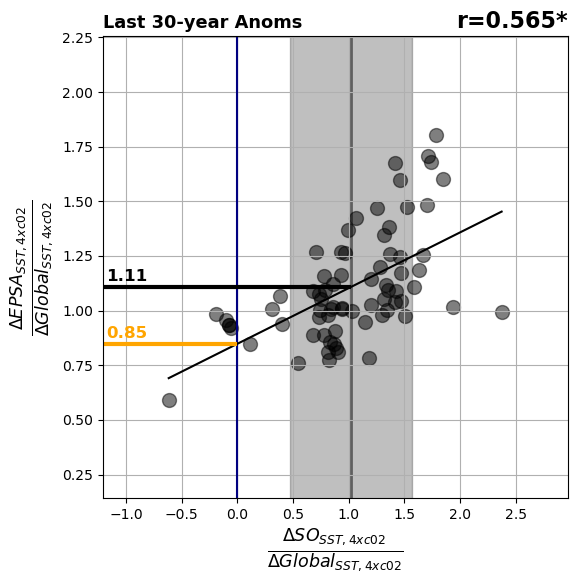

In [ ]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 12*30)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 12*30)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 12*30)).mean(dim="time")["tos"]

epsa_cmip_4xc02_warm = sst_cmip_4xc02.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - sst_cmip_4xc02.isel(time=slice(0, 12*30)).mean(dim="time")["tos"]
epsa_warming = fix_coords_no_time_no_swap(epsa_cmip_4xc02_warm.to_dataset()).sel(lon=slice(-105, -70), lat=slice(-40, -10)).spatial.average("tos")["tos"]

ept_warming = ept_warming / global_warming
so_warming = so_warming / global_warming
epsa_warming = epsa_warming / global_warming

# so_warming = so_warming.where(ept_warming != ept_warming.max(), drop=True)
# ept_warming = ept_warming.where(ept_warming != ept_warming.max(), drop=True)

# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    so_warming, 
    epsa_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\frac{\Delta EPSA_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\frac{\Delta SO_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("Last 30-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept_so_coupled_warming_4xc02_last30yr-anoms.png", dpi=300, bbox_inches="tight")

0.306 0.009


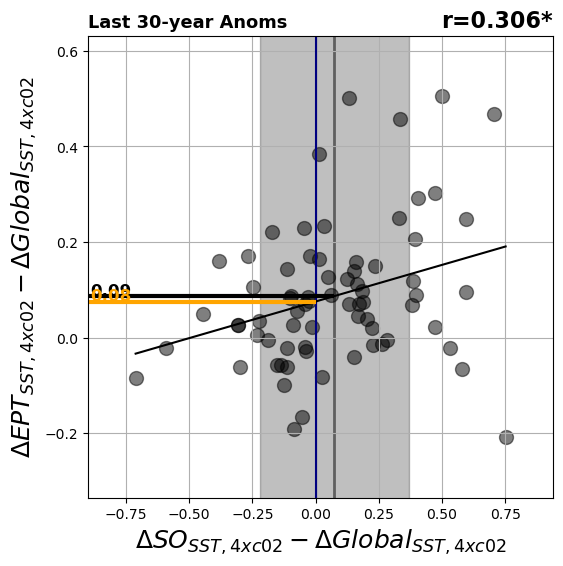

In [305]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]

ept_warming = ept_warming - global_warming
so_warming = so_warming - global_warming

so_warming = so_warming.where(ept_warming != ept_warming.max(), drop=True)
ept_warming = ept_warming.where(ept_warming != ept_warming.max(), drop=True)

# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    so_warming, 
    ept_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\Delta EPT_{SST,4xc02} - \Delta Global_{SST,4xc02}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\Delta SO_{SST,4xc02} - \Delta Global_{SST,4xc02}$", fontsize=axis_fontsize*1.5) 
ax.set_title("Last 30-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept_so_coupled_warming_4xc02_diffs.png", dpi=300, bbox_inches="tight")

We may also postulate that models with larger piControl SO-EPT coupling also have more coupled rates of warming.

-0.085 0.493


Text(0.0, 1.0, 'Last 30-year Anoms')

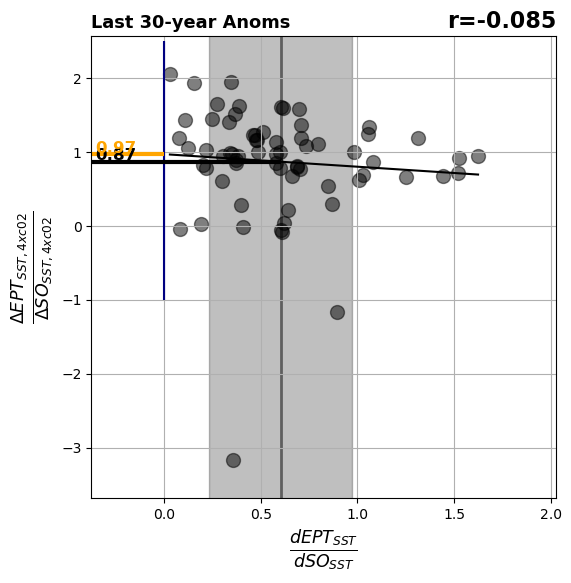

In [313]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(1800-12*30, 1800)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(1800-12*30, 1800)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]

ept_warming = ept_warming #- global_warming
so_warming = so_warming #- global_warming

ratio_warming = so_warming / ept_warming
rval, ratio_warming = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), ratio_warming)


# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval, 
    ratio_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\frac{\Delta EPT_{SST,4xc02}}{\Delta SO_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_title("Last 30-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/ept_so_coupled_warming_4xc02_diffs.png", dpi=300, bbox_inches="tight")

If the magnitude of the forced response in the SO and EPT are only weakly related, maybe the timing of the warming is more strongly related. I.e. models with delayed EPT warming also have delayed SO warming and vise versa....We can check this by changing the time-periods we're slicing

0.203 0.088


Text(0.5, 0, '$\\frac{\\Delta SO_{SST,4xc02}}{\\Delta Global_{SST,4xc02}}$')

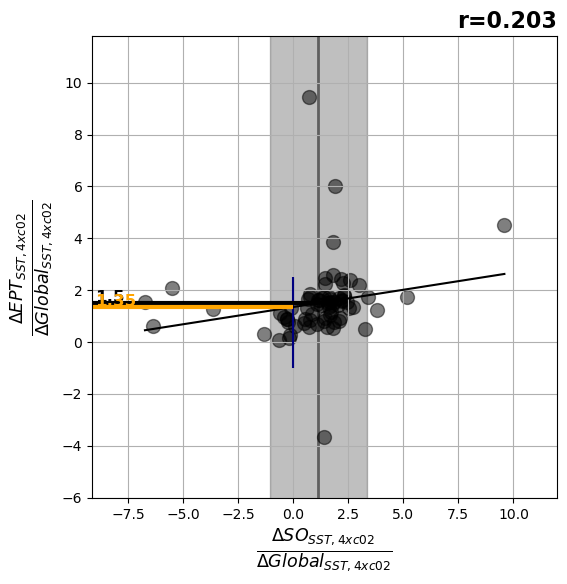

: 

In [315]:
# Last 30 years
ept_warming = cmip_4xc02_ept_sst.isel(time=slice(12*30, 2*12*30)).mean("time")["tos"] - cmip_4xc02_ept_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
global_warming = cmip_4xc02_global_sst.isel(time=slice(12*30, 2*12*30)).mean(dim="time")["tos"] - cmip_4xc02_global_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]
so_warming = cmip_4xc02_so_sst.isel(time=slice(12*30, 2*12*30)).mean("time")["tos"] - cmip_4xc02_so_sst.isel(time=slice(0, 1800)).mean(dim="time")["tos"]

ept_warming = ept_warming / global_warming
so_warming = so_warming / global_warming

so_warming = so_warming.where(ept_warming != ept_warming.max(), drop=True)
ept_warming = ept_warming.where(ept_warming != ept_warming.max(), drop=True)

# plot ept warming vs. so warming
obs_swcf = [0,0]
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    so_warming, 
    ept_warming,
    vline=obs_swcf 
)
ax.grid()
ax.set_ylabel(r"$\frac{\Delta EPT_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
ax.set_xlabel(r"$\frac{\Delta SO_{SST,4xc02}}{\Delta Global_{SST,4xc02}}$", fontsize=axis_fontsize*1.5) 
# ax.set_title("5-year Anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)

# Walker, WE Gradient, and ITCZ Related to SWCF

In [195]:
walker_30yr_trends = calculate_rolling_gradient(walker_anomaly, window = 12*30, name="walker", save=True)
WE_30yr_trends = calculate_rolling_gradient(WE_sst_anomaly, window = 12*30, name="WE_sst", save=True)
ITCZ_30yr_trends = calculate_rolling_gradient(itcz_position, window = 30, name="ITCZ", save=True)

-0.305 0.006


Text(0.0, 1.0, '30-year Trends')

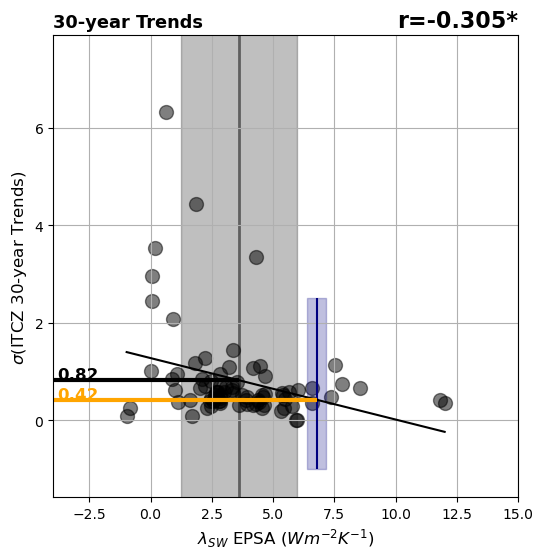

In [196]:
kaxis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
ITCZ_30yr_trends_std, swcf_cmip_epsa = get_shared_models(ITCZ_30yr_trends.std("time"), swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    ITCZ_30yr_trends_std.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"$\sigma$(ITCZ 30-year Trends)", fontsize=axis_fontsize*1) 
ax.set_title("30-year Trends", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcf_epsa_vs_std_30year-WalkerCirc_trend.png", dpi=300, bbox_inches="tight")

-0.179 0.11


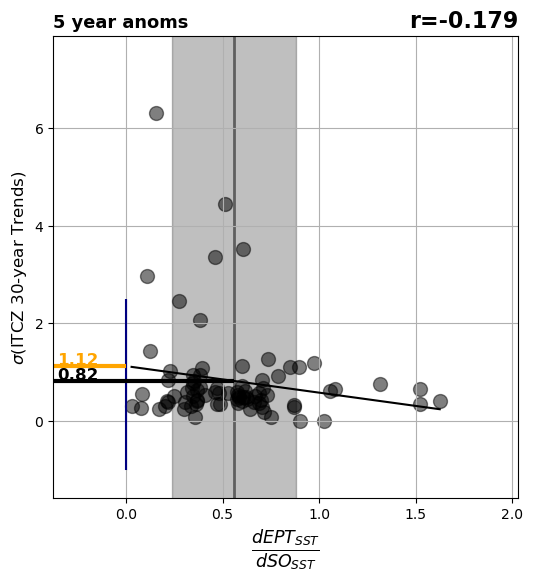

In [197]:
axis_fontsize = 12
title_fontsize = 16

rval, ITCZ_30yr_trends_std = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), ITCZ_30yr_trends_std)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval.values, 
    ITCZ_30yr_trends_std.values,
    vline=[0,0,0]
)
ax.grid()
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_ylabel(r"$\sigma$(ITCZ 30-year Trends)", fontsize=axis_fontsize*1) 
ax.set_title("5 year anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/EPT-SO_coupling_vs_std_30year-ITCZ_trend.png", dpi=300, bbox_inches="tight")

0.208 0.062


Text(0.0, 1.0, '30-year Trends')

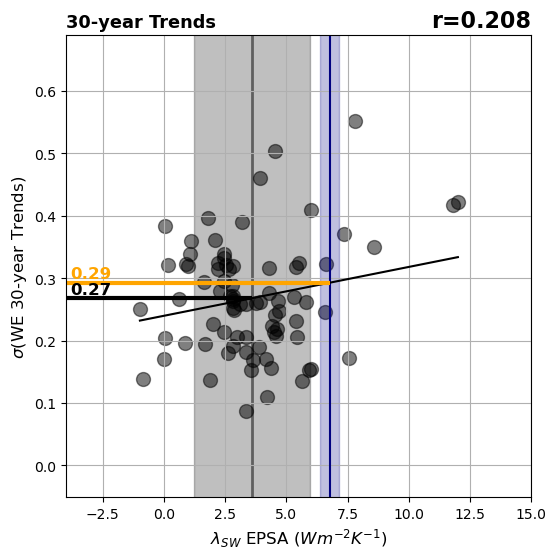

In [198]:
kaxis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
WE_30yr_trends_std, swcf_cmip_epsa = get_shared_models(WE_30yr_trends.std("time"), swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    WE_30yr_trends_std.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"$\sigma$(WE 30-year Trends)", fontsize=axis_fontsize*1) 
ax.set_title("30-year Trends", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcf_epsa_vs_std_30year-WalkerCirc_trend.png", dpi=300, bbox_inches="tight")

0.542 0.0


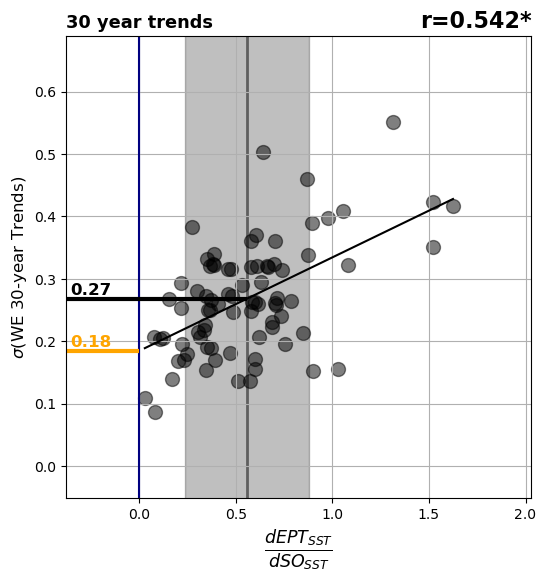

In [199]:
axis_fontsize = 12
title_fontsize = 16

rval, WE_30yr_trends_std = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), WE_30yr_trends_std)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval.values, 
    WE_30yr_trends_std.values,
    vline=[0,0,0]
)
ax.grid()
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_ylabel(r"$\sigma$(WE 30-year Trends)", fontsize=axis_fontsize*1) 
ax.set_title("30 year trends", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/EPT-SO_coupling_vs_std_30year-WE_trend.png", dpi=300, bbox_inches="tight")

0.41 0.0


Text(0.0, 1.0, '30-year Trends')

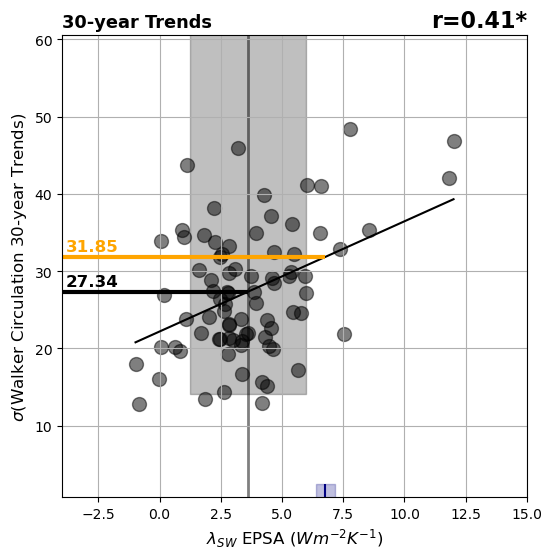

In [200]:
kaxis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
walker_30yr_trends_std, swcf_cmip_epsa = get_shared_models(walker_30yr_trends.std("time"), swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    walker_30yr_trends_std.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"$\sigma$(Walker Circulation 30-year Trends)", fontsize=axis_fontsize*1) 
ax.set_title("30-year Trends", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcf_epsa_vs_std_30year-WalkerCirc_trend.png", dpi=300, bbox_inches="tight")

0.6 0.0


Text(0.0, 1.0, '5 year anoms')

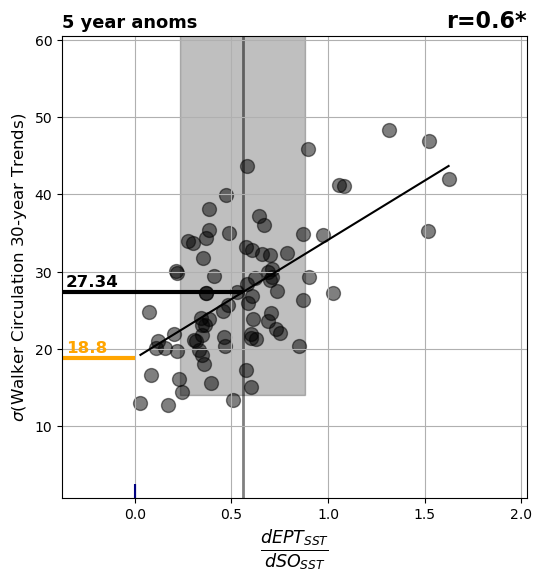

In [201]:
axis_fontsize = 12
title_fontsize = 16

rval, walker_30yr_trends_std = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), walker_30yr_trends_std)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval.values, 
    walker_30yr_trends_std.values,
    vline=[0,0,0]
)
ax.grid()
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_ylabel(r"$\sigma$(Walker Circulation 30-year Trends)", fontsize=axis_fontsize*1) 
ax.set_title("5 year anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/EPT-SO_coupling_vs_std_30year-WalkerCirc_trend.png", dpi=300, bbox_inches="tight")

# ITCZ Precip

In [202]:
# pr_cmip = fix_coords(pr_cmip)
yr = 12*5
pr_cmip_clim = pr_cmip.mean("time")
pr_cmip_clim, so_ept_coupling = get_shared_models(pr_cmip_clim, rvalues_so_ept_coupling.reg.sel(years=yr))
r = xscore.pearson_r(pr_cmip_clim["pr"], so_ept_coupling, dim="model")
p = xscore.pearson_r_eff_p_value(pr_cmip_clim["pr"], so_ept_coupling, dim="model")

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


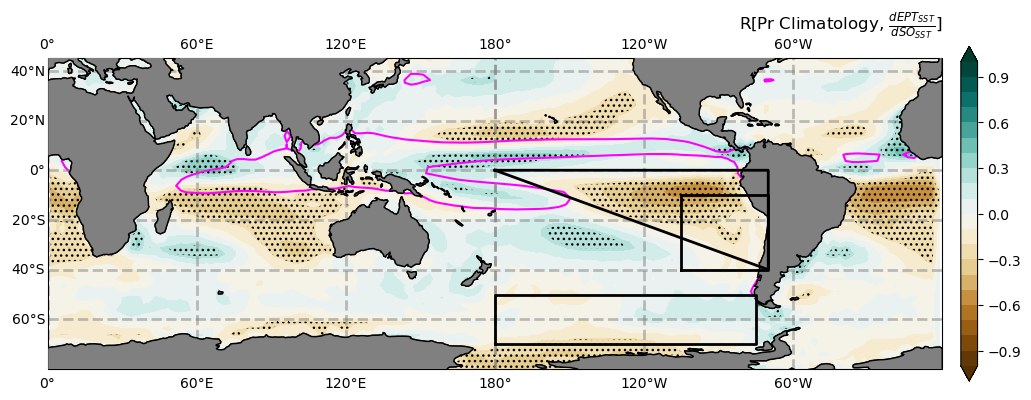

In [203]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r, 
    lat=r.lat,
    lon=r.lon,
    pvalues=p,
    cmap="BrBG",
    cbar_label="",
    levels=np.arange(-1, 1.1, .1),
    pr=(pr_cmip_clim.mean("model")["pr"]*86400).values
)
ax1.set_title(r"R[Pr Climatology, $\frac{dEPT_{SST}}{dSO_{SST}}$]", loc="right", fontsize=title_fontsize*.75)
# ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
# cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/clim-precip_coupling.png", dpi=300, bbox_inches="tight")


In [204]:
# pr_cmip = fix_coords(pr_cmip)
pr_cmip_clim = pr_cmip.mean("time")
pr_cmip_clim, swcf_cmip_epsa = get_shared_models(pr_cmip_clim, swcf_cmip_epsa)
r = xscore.pearson_r(pr_cmip_clim["pr"], swcf_cmip_epsa, dim="model")
p = xscore.pearson_r_eff_p_value(pr_cmip_clim["pr"], swcf_cmip_epsa, dim="model")

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/deterministic.py:462: UserWarning: ['model'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


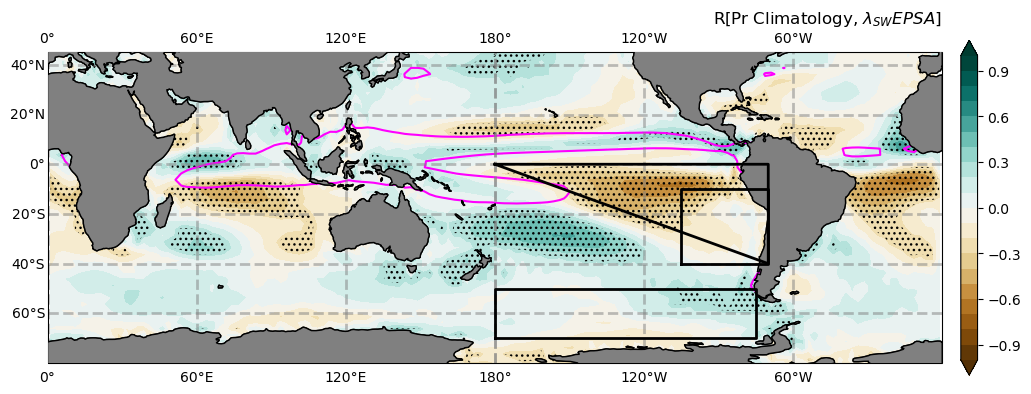

In [205]:
fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Map (top row)

axis_fontsize = 12
title_fontsize = 16

# Plot spatial map
img = _global_plot(
    ax1,
    data=r, 
    lat=r.lat,
    lon=r.lon,
    pvalues=p,
    cmap="BrBG",
    cbar_label="",
    levels=np.arange(-1, 1.1, .1),
    pr=(pr_cmip_clim.mean("model")["pr"]*86400).values
)
ax1.set_title(r"R[Pr Climatology, $\lambda_{SW} EPSA$]", loc="right", fontsize=title_fontsize*.75)
# ax1.set_title(r"5-year", loc="left", fontsize=title_fontsize*.75)
# cbar = fig.colorbar(img, ax=ax1, orientation='vertical', fraction=.020, pad=.01)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/clim-precip_swcf_epsa.png", dpi=300, bbox_inches="tight")


0.508 0.0


Text(0.0, 1.0, '')

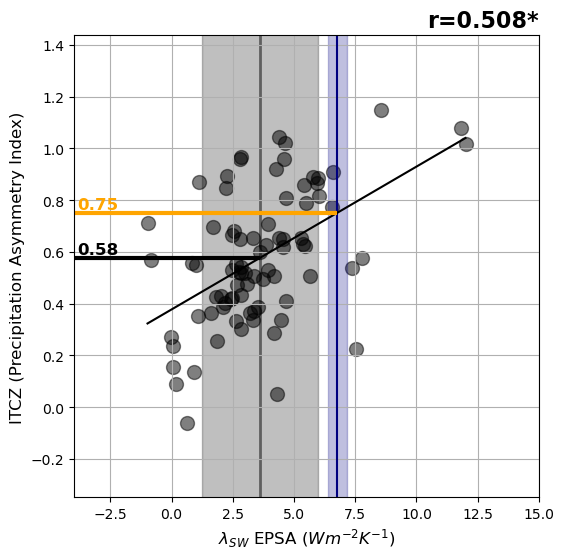

In [207]:
axis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
paiep_clim_sm, swcf_cmip_epsa = get_shared_models(paiep_clim, swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    paiep_clim_sm.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"ITCZ (Precipitation Asymmetry Index)", fontsize=axis_fontsize*1) 
ax.set_title("", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcf_epsa_vs_itcz_pai_clim.png", dpi=300, bbox_inches="tight")

In [208]:
for yr in rvalues_so_ept_coupling.years:
    rval, paiep_clim_sm = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=yr), paiep_clim)
    reg = linregress(paiep_clim_sm.values, rval.values)
    print(yr.values, reg.rvalue)

1 0.2797649090117117
2 0.297717558790011
3 0.3203694667641776
4 0.3435187352126293
5 0.3604252420675985
6 0.38114021574876705
7 0.4000464772248567
8 0.41918582100464674
9 0.43574540576919124
10 0.44698601586073666
11 0.44501808861912706
12 0.4377839180711781
24 0.4615620090012708
36 0.4849676210052656
48 0.49060487779766326
60 0.4681240725586953
72 0.42945844932512867
84 0.3949325246091212
96 0.36719592141204505
108 0.3414492692749436
120 0.3159559510536799
132 0.295732974829154
144 0.2810642965199299
156 0.26419748642222335
168 0.24660839514202235
180 0.23403260063537545
192 0.22531736273266853
204 0.21579611900004284
216 0.20213181024537855
228 0.1900131932814929
240 0.18498188663648774
252 0.18089154920191752
264 0.17386574518039127
276 0.17051286862626527
288 0.17166037832756995
300 0.17186922608903243
312 0.1690136889182797
324 0.16852708433415572
336 0.17090162056539657
348 0.17264891354589176
360 0.172139803324408


0.468 0.0


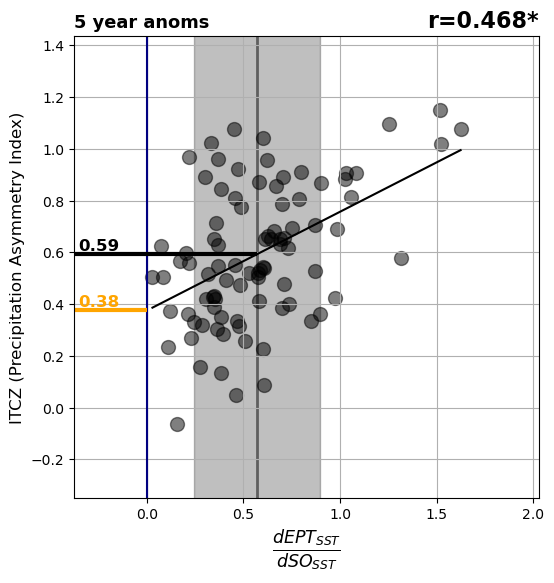

In [209]:
axis_fontsize = 12
title_fontsize = 16

rval, paiep_clim_sm = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), paiep_clim)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval.values, 
    paiep_clim_sm.values,
    vline=[0,0] #obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_ylabel(r"ITCZ (Precipitation Asymmetry Index)", fontsize=axis_fontsize*1) 
ax.set_title("5 year anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# ax.set_title("", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/coupling_vs_itcz_pai_clim.png", dpi=300, bbox_inches="tight")

-0.498 0.0


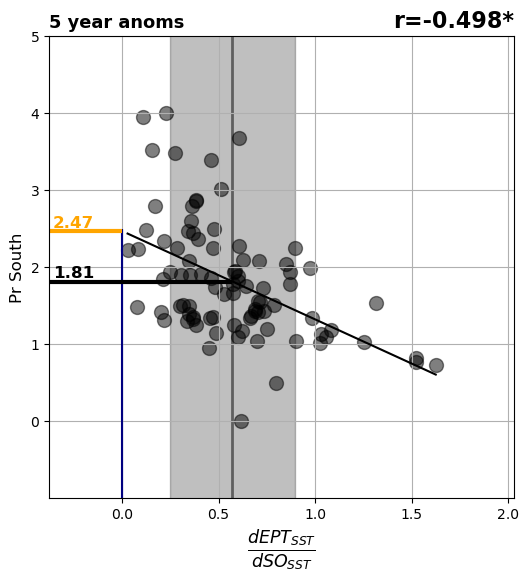

In [214]:
axis_fontsize = 12
title_fontsize = 16

rval, pr_south_east_clim = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=12*5), pr_south_east_clim)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    rval.values, 
    pr_south_east_clim.values,
    vline=[0,0] #obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\frac{d EPT_{SST}}{dSO_{SST}}$", fontsize=axis_fontsize*1.5) 
ax.set_ylabel(r"Pr South", fontsize=axis_fontsize*1) 
ax.set_title("5 year anoms", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
# ax.set_title("", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/coupling_vs_pr_south_clim.png", dpi=300, bbox_inches="tight")

-0.592 0.0


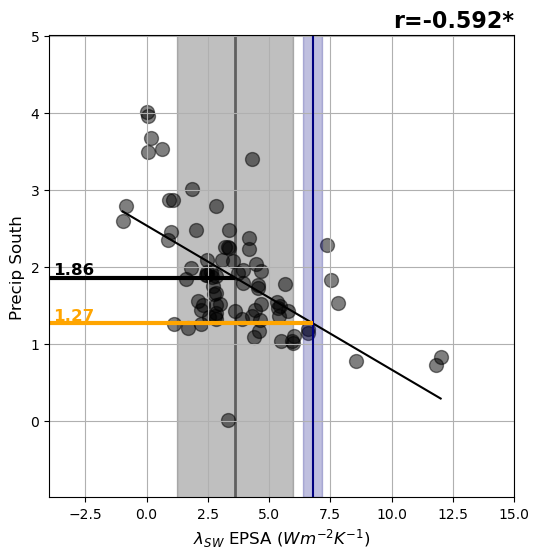

In [225]:
axis_fontsize = 12
title_fontsize = 16

obs_swcf = [7.00834229, 7.2915155, 6.78656787, 6.65187705, 6.13171316]
pr_south_east_clim, swcf_cmip_epsa = get_shared_models(pr_south_east_clim, swcf_cmip_epsa)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
create_panel_a(
    ax,
    swcf_cmip_epsa.values, 
    pr_south_east_clim.values,
    vline=obs_swcf 
)
ax.grid()
ax.set_xlabel(r"$\lambda_{SW}$ EPSA ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
ax.set_ylabel(r"Precip South", fontsize=axis_fontsize*1) 
ax.set_title("", loc="left", fontweight="bold", fontsize=title_fontsize/1.25)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/swcf_epsa_vs_pr_south_east_clim.png", dpi=300, bbox_inches="tight")

In [218]:
for yr in rvalues_so_ept_coupling.years:
    # rval, pr_south_east_clim = get_shared_models(rvalues_so_ept_coupling["reg"].sel(years=yr), pr_south_east_clim)
    rval, pr_south_east_clim = get_shared_models(swcf_cmip_epsa, pr_south_east_clim)
    reg = linregress(pr_south_east_clim.values, rval.values)
    print(yr.values, reg.rvalue)

1 -0.5922209302367044
2 -0.5922209302367044
3 -0.5922209302367044
4 -0.5922209302367044
5 -0.5922209302367044
6 -0.5922209302367044
7 -0.5922209302367044
8 -0.5922209302367044
9 -0.5922209302367044
10 -0.5922209302367044
11 -0.5922209302367044
12 -0.5922209302367044
24 -0.5922209302367044
36 -0.5922209302367044
48 -0.5922209302367044
60 -0.5922209302367044
72 -0.5922209302367044
84 -0.5922209302367044
96 -0.5922209302367044
108 -0.5922209302367044
120 -0.5922209302367044
132 -0.5922209302367044
144 -0.5922209302367044
156 -0.5922209302367044
168 -0.5922209302367044
180 -0.5922209302367044
192 -0.5922209302367044
204 -0.5922209302367044
216 -0.5922209302367044
228 -0.5922209302367044
240 -0.5922209302367044
252 -0.5922209302367044
264 -0.5922209302367044
276 -0.5922209302367044
288 -0.5922209302367044
300 -0.5922209302367044
312 -0.5922209302367044
324 -0.5922209302367044
336 -0.5922209302367044
348 -0.5922209302367044
360 -0.5922209302367044
